In [ ]:
# !pip install torchvision tensorboardx jupyter matplotlib numpy

In [ ]:
import torch
from torch import nn,optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import os
import numpy as np
import errno
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
from IPython import display
from matplotlib import pyplot as plt
import torch

'''
    TensorBoard Data will be stored in './runs' path
'''


class Logger:

    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)

    def log(self, d_error, g_error, epoch, n_batch, num_batches):

        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(
            '{}/D_error'.format(self.comment), d_error, step)
        self.writer.add_scalar(
            '{}/G_error'.format(self.comment), g_error, step)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        '''
        input images are expected in format (NCHW)
        '''
        if type(images) == np.ndarray:
            images = torch.from_numpy(images)
        
        if format=='NHWC':
            images = images.transpose(1,3)
        

        step = Logger._step(epoch, n_batch, num_batches)
        img_name = '{}/images{}'.format(self.comment, '')

        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)
        # Make vertical grid from image tensor
        nrows = int(np.sqrt(num_images))
        grid = vutils.make_grid(
            images, nrow=nrows, normalize=True, scale_each=True)

        # Add horizontal images to tensorboard
        self.writer.add_image(img_name, horizontal_grid, step)

        # Save plots
        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)

        # Plot and save horizontal
        fig = plt.figure(figsize=(16, 16))
        plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
        plt.axis('off')
        if plot_horizontal:
            display.display(plt.gcf())
        self._save_images(fig, epoch, n_batch, 'hori')
        plt.close()

        # Save squared
        fig = plt.figure()
        plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
        plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,
                                                         comment, epoch, n_batch))

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):
        
        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()
        if isinstance(d_pred_real, torch.autograd.Variable):
            d_pred_real = d_pred_real.data
        if isinstance(d_pred_fake, torch.autograd.Variable):
            d_pred_fake = d_pred_fake.data
        
        
        print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    def save_models(self, generator, discriminator, epoch):
        out_dir = './data/models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(),
                   '{}/G_epoch_{}'.format(out_dir, epoch))
        torch.save(discriminator.state_dict(),
                   '{}/D_epoch_{}'.format(out_dir, epoch))

    def close(self):
        self.writer.close()

    # Private Functionality

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

In [ ]:
def mnist_data():
  compose = transforms.Compose(
      [transforms.ToTensor(),
       transforms.Normalize((.5),(.5))]
  )
  out_dir = './dataset'
  return datasets.MNIST(root=out_dir,train=True,
                        transform=compose,download=True)
  
#load data
data = mnist_data()

data_loader = torch.utils.data.DataLoader(data,batch_size=100,shuffle=True)

num_batches = len(data_loader)

  

In [ ]:
class DiscriminatorNet(torch.nn.Module):

  def __init__(self):
    super(DiscriminatorNet,self).__init__()
    n_features = 784
    n_out = 1

    self.hidden0 = nn.Sequential(
        nn.Linear(n_features,1024),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3)
    )
    self.hidden1 = nn.Sequential(
        nn.Linear(1024,512),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3)
    )
    self.hidden2 = nn.Sequential(
        nn.Linear(512,256),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3)
    )
    self.out = nn.Sequential(
        torch.nn.Linear(256,n_out),
        torch.nn.Sigmoid()
    )

  def forward(self,x):
    x = self.hidden0(x)
    x = self.hidden1(x)
    x = self.hidden2(x)
    x = self.out(x)
    return x

discriminator = DiscriminatorNet().to(device)

In [ ]:
def images_to_vectors(images):
  return images.view(images.size(0),784)

def vectors_to_images(vectors):
  return vectors.view(vectors.size(0),1,28,28)

In [ ]:
class GeneratorNet(torch.nn.Module):
  def __init__(self):
    super(GeneratorNet,self).__init__()
    n_features = 100
    n_out = 784

    self.hidden0 = nn.Sequential(
        nn.Linear(n_features,256),
        nn.LeakyReLU(0.2)
    )
    self.hidden1 = nn.Sequential(
        nn.Linear(256,512),
        nn.LeakyReLU(0.2)
    )
    self.hidden2 = nn.Sequential(
        nn.Linear(512,1024),
        nn.LeakyReLU(0.2)
    )
    self.out = nn.Sequential(
        nn.Linear(1024,n_out),
        nn.Tanh()
    )

  def forward(self,x):
    x = self.hidden0(x)
    x = self.hidden1(x)
    x = self.hidden2(x)
    x = self.out(x)
    return x
generator = GeneratorNet().to(device)

In [ ]:
def noise(size):
  n = Variable(torch.randn(size,100))
  return n

In [ ]:
d_optimizer = optim.Adam(discriminator.parameters(),lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(),lr=0.0002)

In [ ]:
loss = nn.BCELoss()

In [ ]:
def ones_target(size):
  data = Variable(torch.ones(size,1))
  return data

def zeros_target(size):
  data = Variable(torch.zeros(size,1))
  return data

In [ ]:
def train_discriminator(optimizer,real_data,fake_data):
  N= real_data.size(0)
  #Reset gradients
  optimizer.zero_grad()

  # Train on real
  # Calculate error and backpropagate
  prediction_real = discriminator(real_data)
  error_real = loss(prediction_real, ones_target(N).to(device))
  error_real.backward()

  # train on fake
  # calc error and backpropagate
  prediction_fake = discriminator(fake_data)
  error_fake = loss(prediction_fake,zeros_target(N).to(device))
  error_fake.backward()

  # update weights 
  optimizer.step()

  return error_real + error_fake,prediction_real,prediction_fake

In [ ]:
def train_generator(optimizer,fake_data):
  N = fake_data.size(0)

  # reset the gradients
  optimizer.zero_grad()

  # Sample noise and generate fake data
  prediction = discriminator(fake_data)

  # Calculate error and backprobagate
  error = loss(prediction,ones_target(N).to(device))
  error.backward()

  #update weights with gradients
  optimizer.step()

  return error

In [ ]:
num_test_samples = 16
test_noise = noise(num_test_samples)

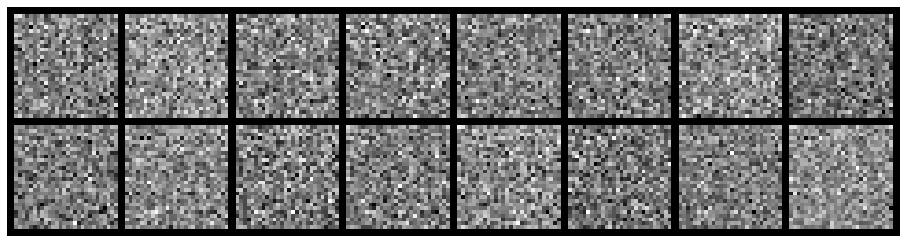

Epoch: [0/200], Batch Num: [0/600]
Discriminator Loss: 1.3785, Generator Loss: 0.6905
D(x): 0.5056, D(G(z)): 0.5014


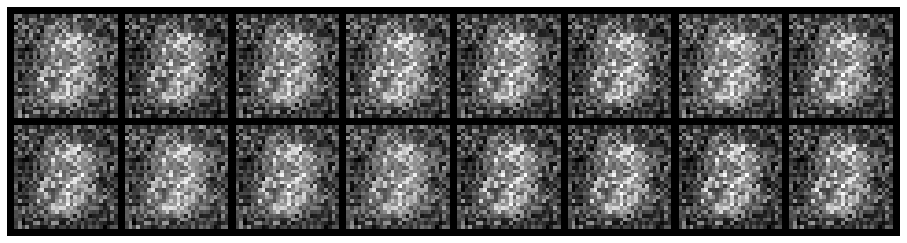

Epoch: [0/200], Batch Num: [100/600]
Discriminator Loss: 1.9514, Generator Loss: 0.4106
D(x): 0.6075, D(G(z)): 0.7306


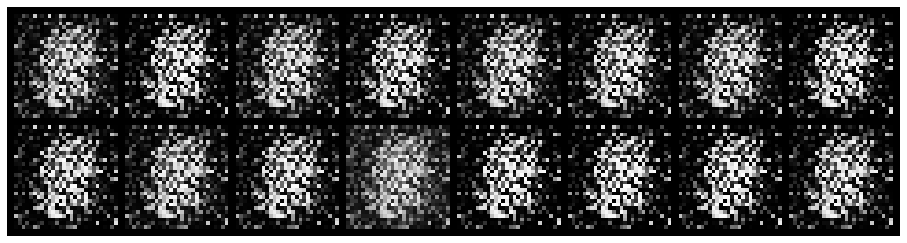

Epoch: [0/200], Batch Num: [200/600]
Discriminator Loss: 0.0478, Generator Loss: 8.7723
D(x): 0.9916, D(G(z)): 0.0353


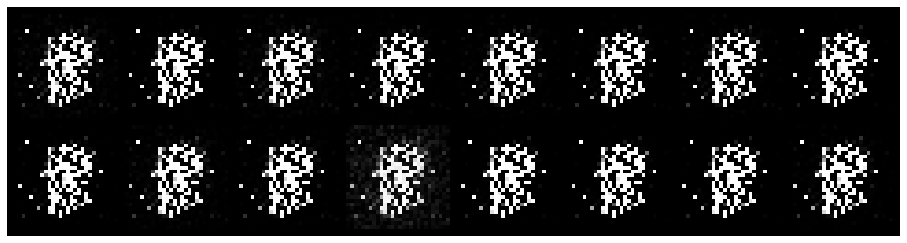

Epoch: [0/200], Batch Num: [300/600]
Discriminator Loss: 0.0293, Generator Loss: 6.1983
D(x): 0.9842, D(G(z)): 0.0116


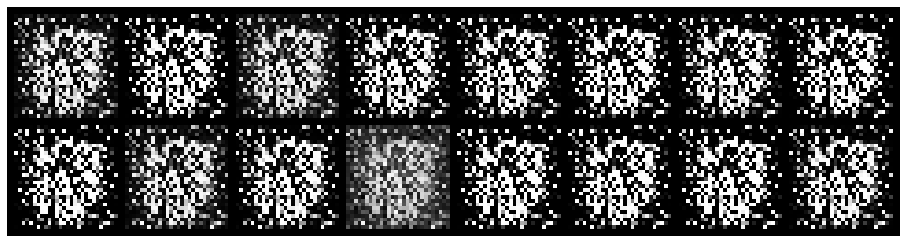

Epoch: [0/200], Batch Num: [400/600]
Discriminator Loss: 0.1433, Generator Loss: 6.7350
D(x): 0.9365, D(G(z)): 0.0314


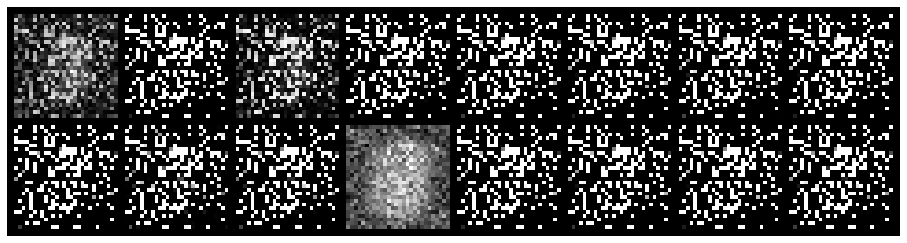

Epoch: [0/200], Batch Num: [500/600]
Discriminator Loss: 0.0780, Generator Loss: 7.1562
D(x): 0.9856, D(G(z)): 0.0489


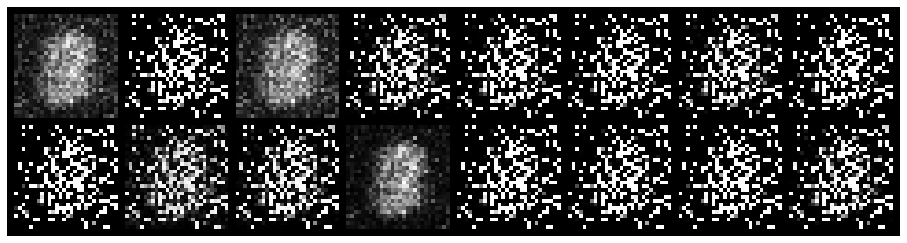

Epoch: [1/200], Batch Num: [0/600]
Discriminator Loss: 0.4352, Generator Loss: 6.4628
D(x): 0.8615, D(G(z)): 0.1536


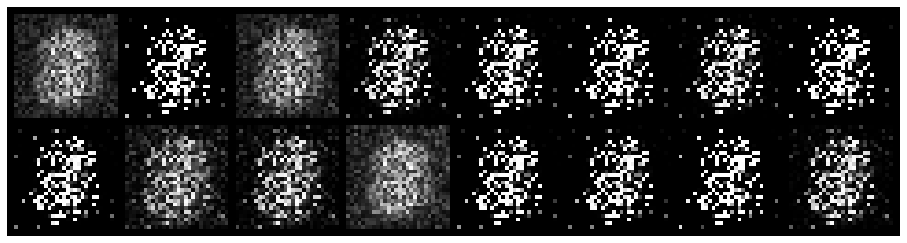

Epoch: [1/200], Batch Num: [100/600]
Discriminator Loss: 0.4512, Generator Loss: 5.9020
D(x): 0.8651, D(G(z)): 0.2025


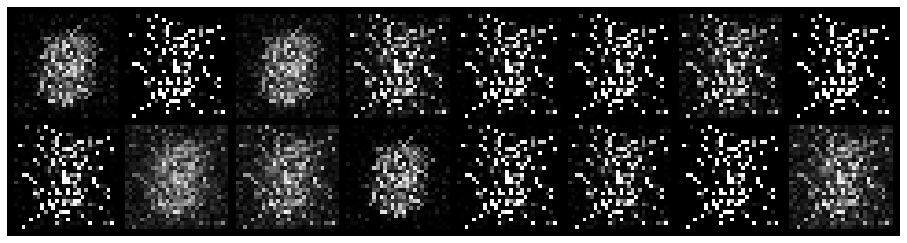

Epoch: [1/200], Batch Num: [200/600]
Discriminator Loss: 0.4015, Generator Loss: 5.9517
D(x): 0.8114, D(G(z)): 0.0826


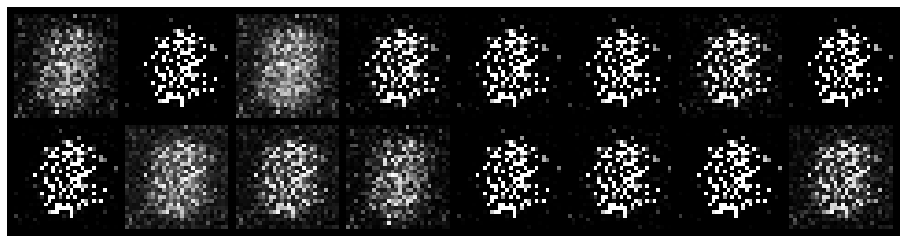

Epoch: [1/200], Batch Num: [300/600]
Discriminator Loss: 0.2630, Generator Loss: 6.2043
D(x): 0.8884, D(G(z)): 0.0657


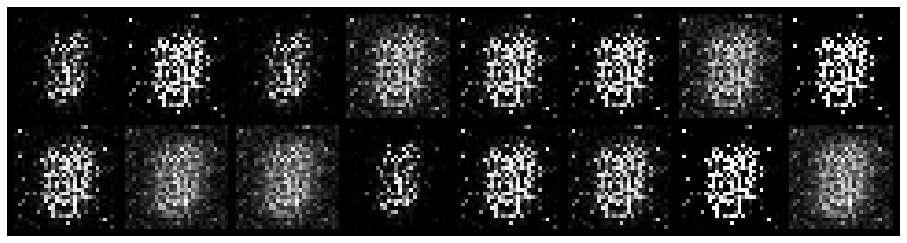

Epoch: [1/200], Batch Num: [400/600]
Discriminator Loss: 0.3257, Generator Loss: 4.2949
D(x): 0.8707, D(G(z)): 0.1235


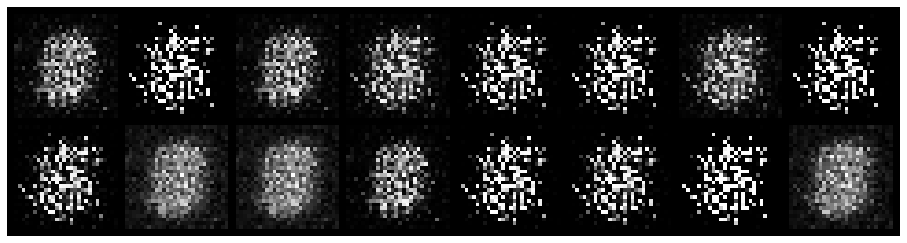

Epoch: [1/200], Batch Num: [500/600]
Discriminator Loss: 0.8939, Generator Loss: 4.5465
D(x): 0.7842, D(G(z)): 0.2389


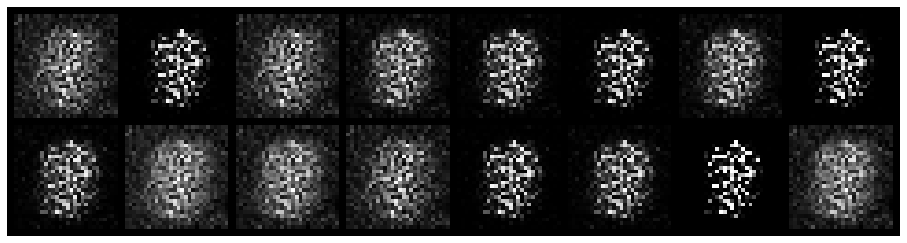

Epoch: [2/200], Batch Num: [0/600]
Discriminator Loss: 1.1224, Generator Loss: 1.7875
D(x): 0.6270, D(G(z)): 0.3787


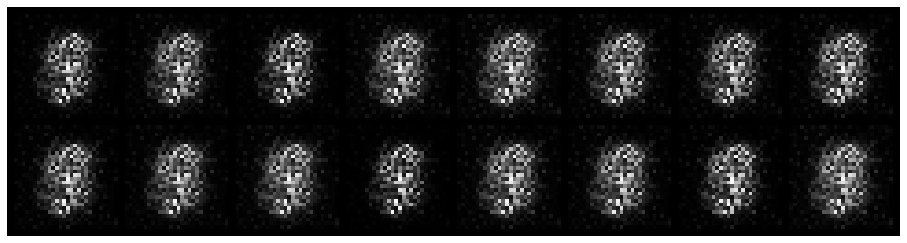

Epoch: [2/200], Batch Num: [100/600]
Discriminator Loss: 0.7976, Generator Loss: 3.1657
D(x): 0.7031, D(G(z)): 0.2234


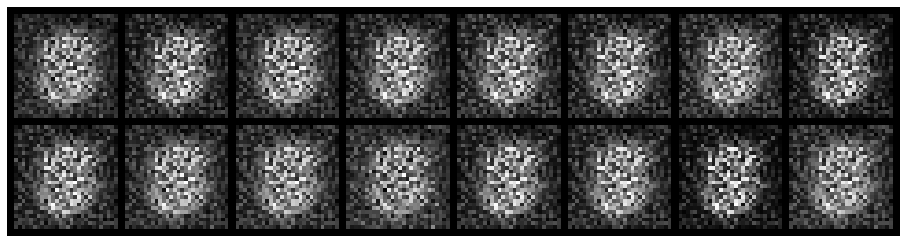

Epoch: [2/200], Batch Num: [200/600]
Discriminator Loss: 0.5717, Generator Loss: 2.6279
D(x): 0.8513, D(G(z)): 0.2546


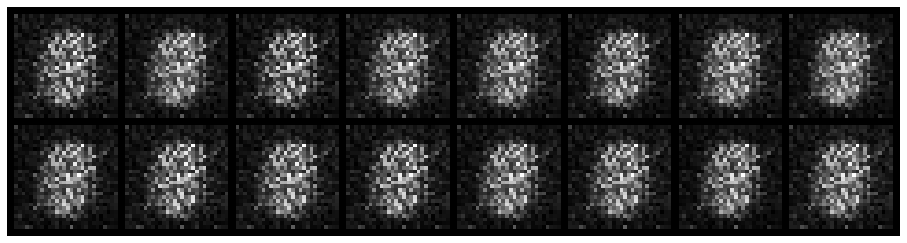

Epoch: [2/200], Batch Num: [300/600]
Discriminator Loss: 0.3803, Generator Loss: 4.5702
D(x): 0.8974, D(G(z)): 0.1345


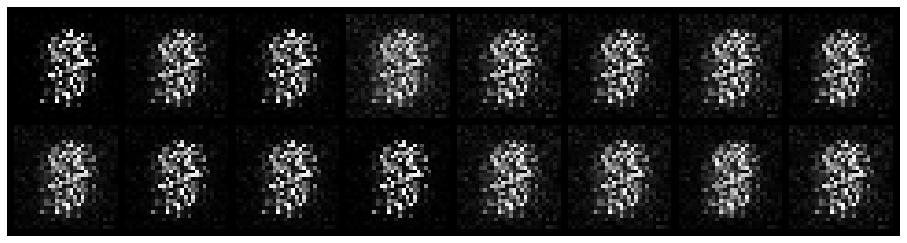

Epoch: [2/200], Batch Num: [400/600]
Discriminator Loss: 1.1164, Generator Loss: 4.3701
D(x): 0.7023, D(G(z)): 0.3237


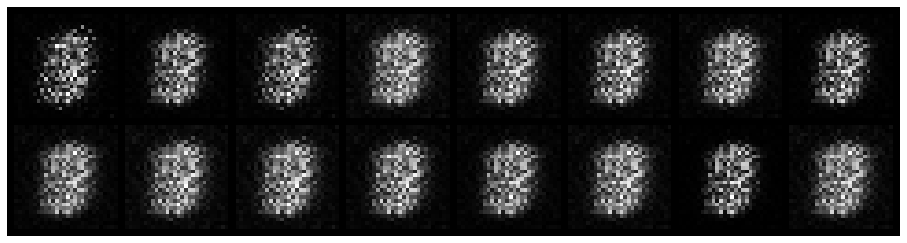

Epoch: [2/200], Batch Num: [500/600]
Discriminator Loss: 0.8372, Generator Loss: 1.3916
D(x): 0.6535, D(G(z)): 0.3013


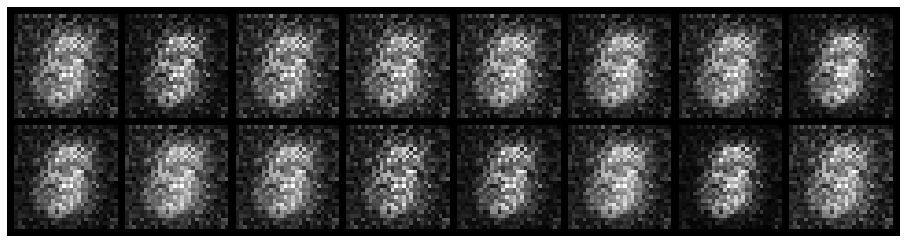

Epoch: [3/200], Batch Num: [0/600]
Discriminator Loss: 0.4338, Generator Loss: 4.8400
D(x): 0.9178, D(G(z)): 0.1673


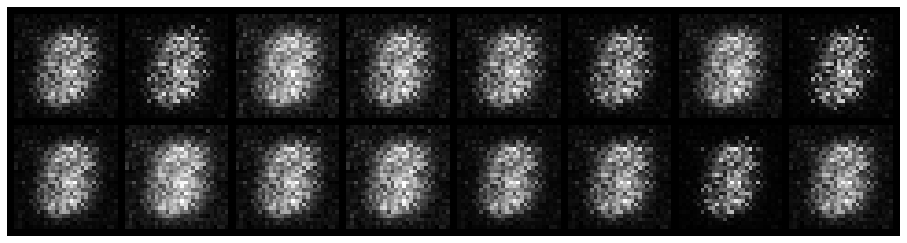

Epoch: [3/200], Batch Num: [100/600]
Discriminator Loss: 0.5573, Generator Loss: 2.4922
D(x): 0.8127, D(G(z)): 0.2336


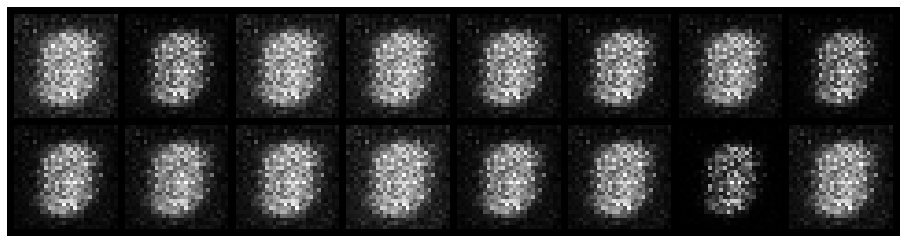

Epoch: [3/200], Batch Num: [200/600]
Discriminator Loss: 0.4494, Generator Loss: 4.4944
D(x): 0.8362, D(G(z)): 0.1645


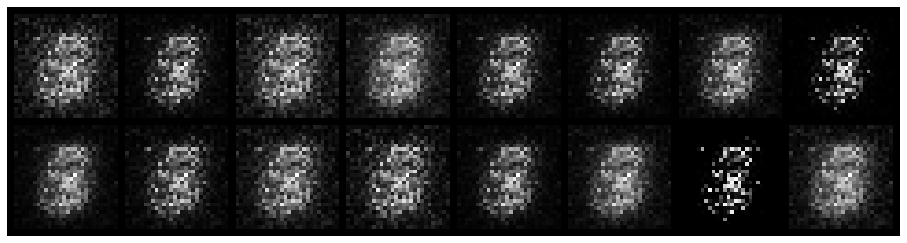

Epoch: [3/200], Batch Num: [300/600]
Discriminator Loss: 0.3784, Generator Loss: 3.7524
D(x): 0.8449, D(G(z)): 0.0775


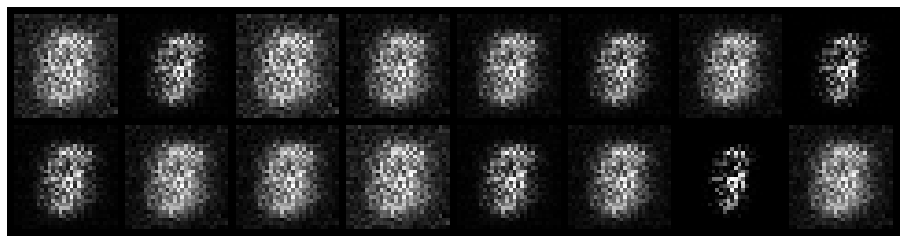

Epoch: [3/200], Batch Num: [400/600]
Discriminator Loss: 0.7390, Generator Loss: 1.7953
D(x): 0.7230, D(G(z)): 0.2172


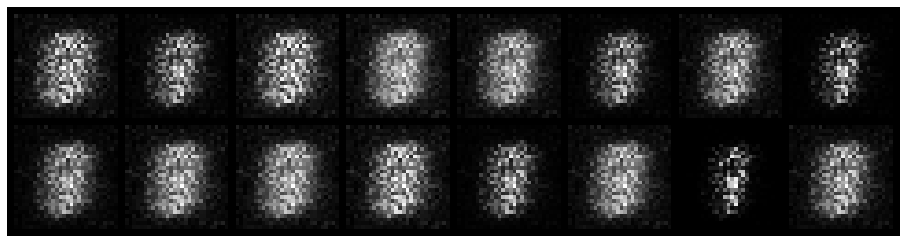

Epoch: [3/200], Batch Num: [500/600]
Discriminator Loss: 0.5583, Generator Loss: 3.7277
D(x): 0.8292, D(G(z)): 0.1501


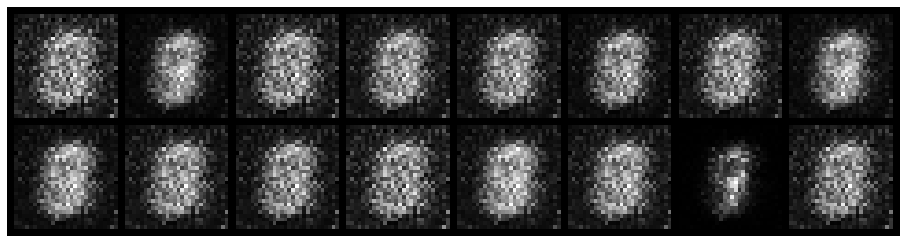

Epoch: [4/200], Batch Num: [0/600]
Discriminator Loss: 0.5039, Generator Loss: 3.7637
D(x): 0.8662, D(G(z)): 0.2236


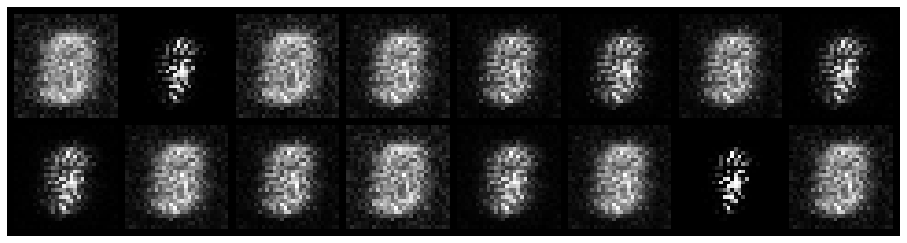

Epoch: [4/200], Batch Num: [100/600]
Discriminator Loss: 0.3916, Generator Loss: 4.3454
D(x): 0.9140, D(G(z)): 0.1382


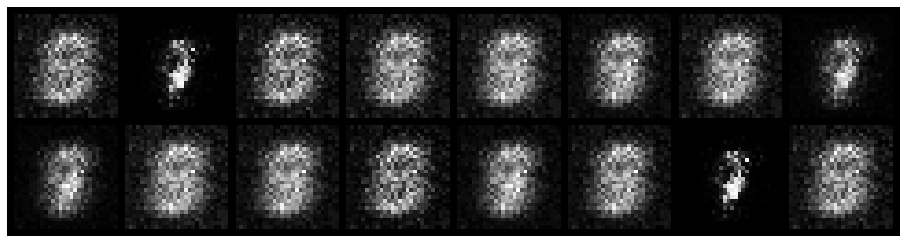

Epoch: [4/200], Batch Num: [200/600]
Discriminator Loss: 0.1232, Generator Loss: 4.1582
D(x): 0.9577, D(G(z)): 0.0464


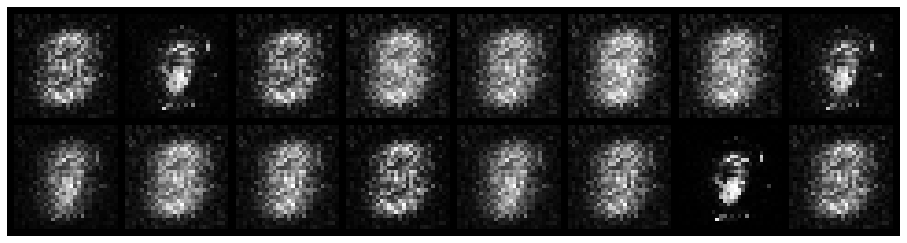

Epoch: [4/200], Batch Num: [300/600]
Discriminator Loss: 0.3359, Generator Loss: 3.8296
D(x): 0.9236, D(G(z)): 0.1367


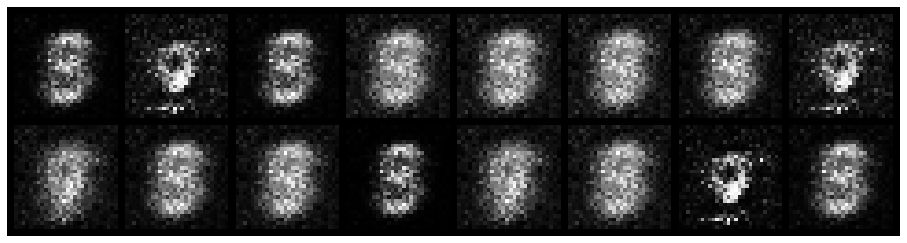

Epoch: [4/200], Batch Num: [400/600]
Discriminator Loss: 0.2512, Generator Loss: 5.0311
D(x): 0.9281, D(G(z)): 0.0770


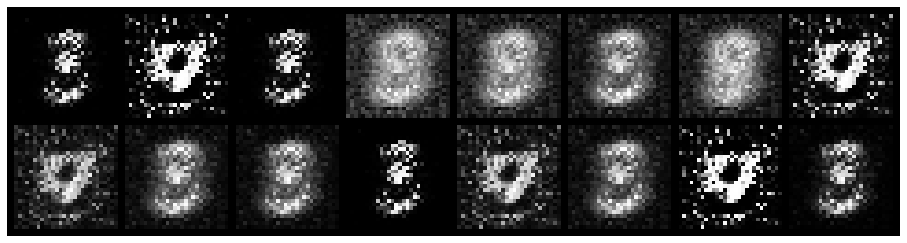

Epoch: [4/200], Batch Num: [500/600]
Discriminator Loss: 0.2259, Generator Loss: 6.1512
D(x): 0.9390, D(G(z)): 0.0968


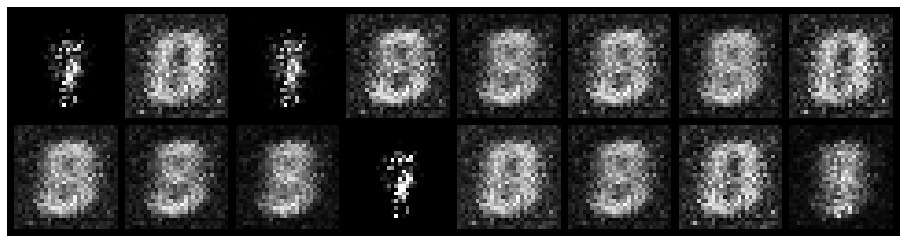

Epoch: [5/200], Batch Num: [0/600]
Discriminator Loss: 0.6754, Generator Loss: 3.6327
D(x): 0.8832, D(G(z)): 0.2435


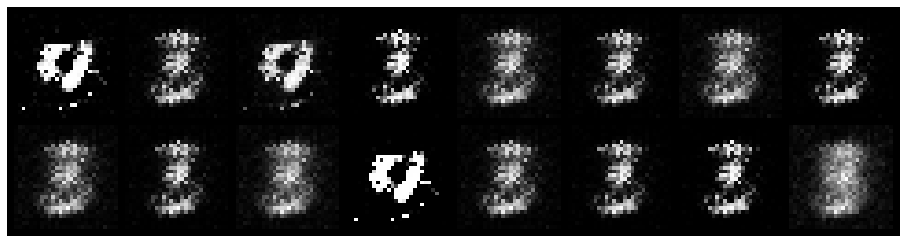

Epoch: [5/200], Batch Num: [100/600]
Discriminator Loss: 0.1920, Generator Loss: 3.4570
D(x): 0.9462, D(G(z)): 0.1020


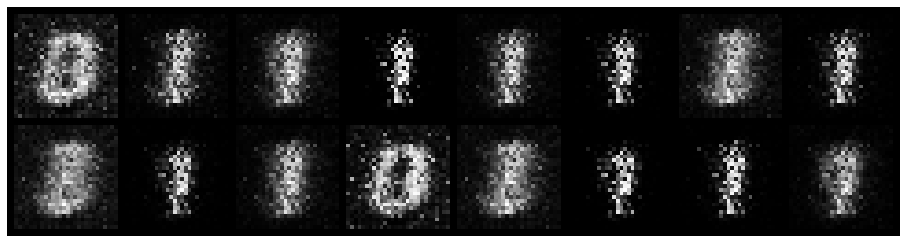

Epoch: [5/200], Batch Num: [200/600]
Discriminator Loss: 0.3288, Generator Loss: 3.4728
D(x): 0.9029, D(G(z)): 0.1150


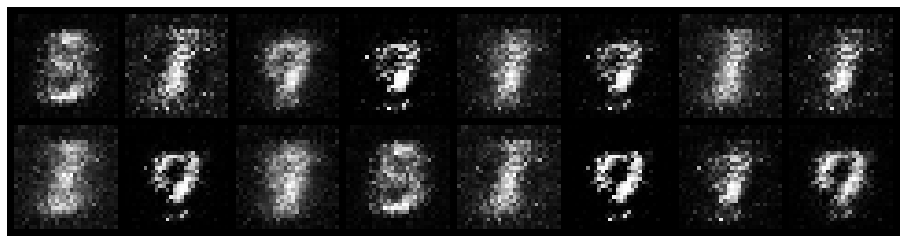

Epoch: [5/200], Batch Num: [300/600]
Discriminator Loss: 0.7706, Generator Loss: 3.4090
D(x): 0.7697, D(G(z)): 0.1329


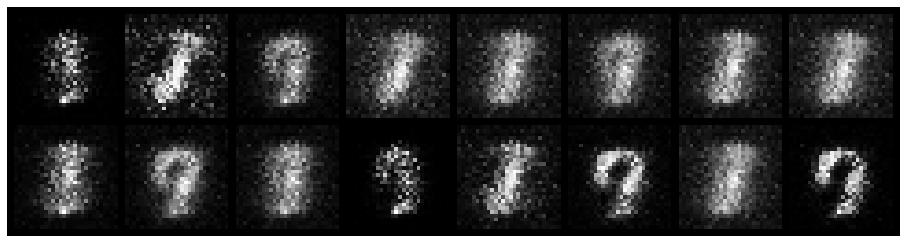

Epoch: [5/200], Batch Num: [400/600]
Discriminator Loss: 0.6309, Generator Loss: 4.1757
D(x): 0.8328, D(G(z)): 0.1972


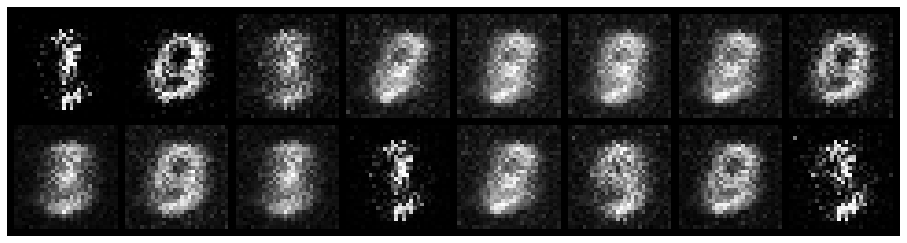

Epoch: [5/200], Batch Num: [500/600]
Discriminator Loss: 0.2723, Generator Loss: 3.8559
D(x): 0.9472, D(G(z)): 0.1324


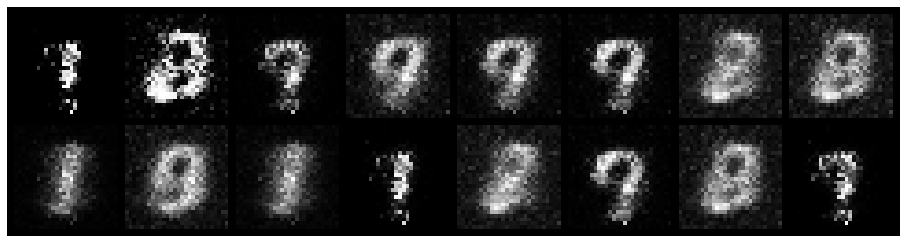

Epoch: [6/200], Batch Num: [0/600]
Discriminator Loss: 0.5264, Generator Loss: 3.9194
D(x): 0.8896, D(G(z)): 0.1632


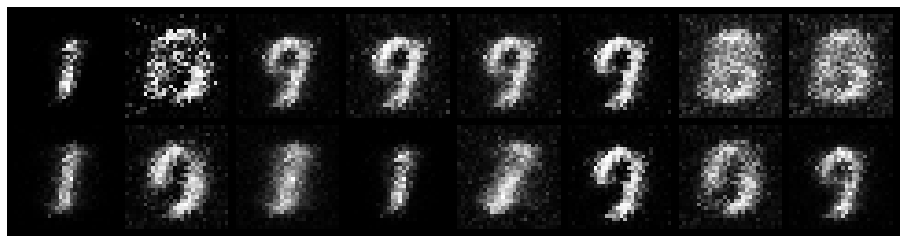

Epoch: [6/200], Batch Num: [100/600]
Discriminator Loss: 0.4078, Generator Loss: 3.4814
D(x): 0.8623, D(G(z)): 0.1053


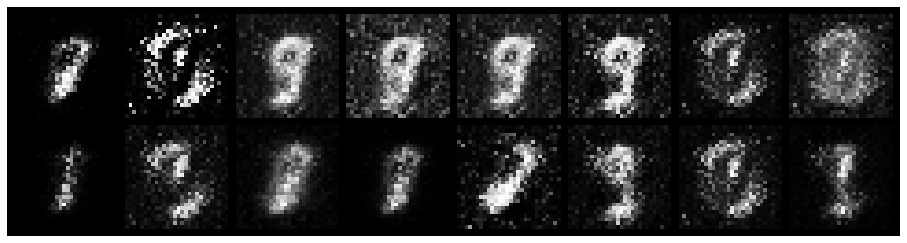

Epoch: [6/200], Batch Num: [200/600]
Discriminator Loss: 0.5242, Generator Loss: 3.1214
D(x): 0.8564, D(G(z)): 0.1584


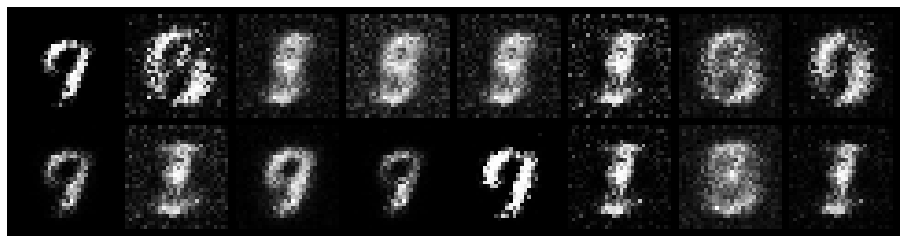

Epoch: [6/200], Batch Num: [300/600]
Discriminator Loss: 0.5116, Generator Loss: 3.4971
D(x): 0.8107, D(G(z)): 0.1262


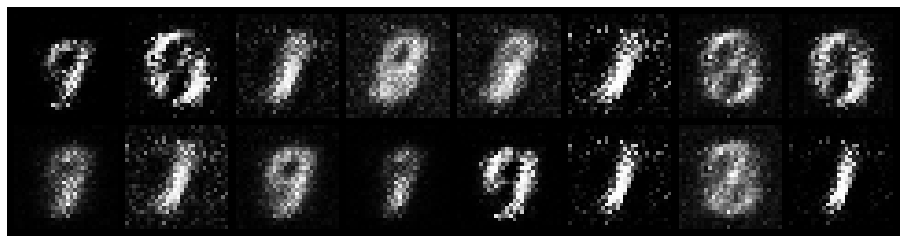

Epoch: [6/200], Batch Num: [400/600]
Discriminator Loss: 0.3062, Generator Loss: 3.6791
D(x): 0.9273, D(G(z)): 0.1188


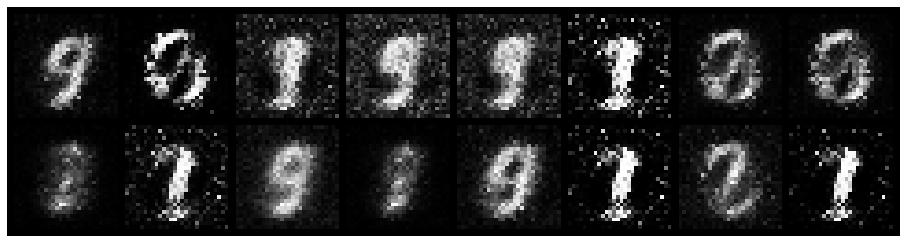

Epoch: [6/200], Batch Num: [500/600]
Discriminator Loss: 0.6229, Generator Loss: 2.4193
D(x): 0.8215, D(G(z)): 0.1977


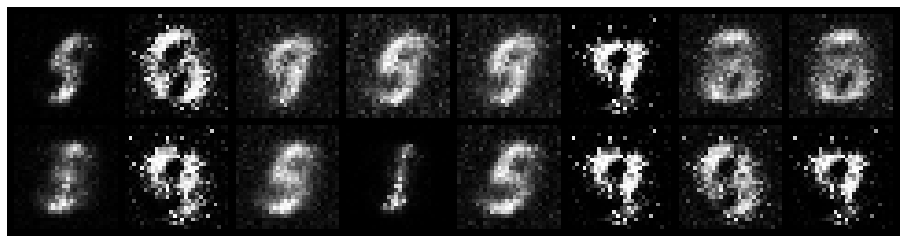

Epoch: [7/200], Batch Num: [0/600]
Discriminator Loss: 0.3688, Generator Loss: 3.5337
D(x): 0.8664, D(G(z)): 0.0791


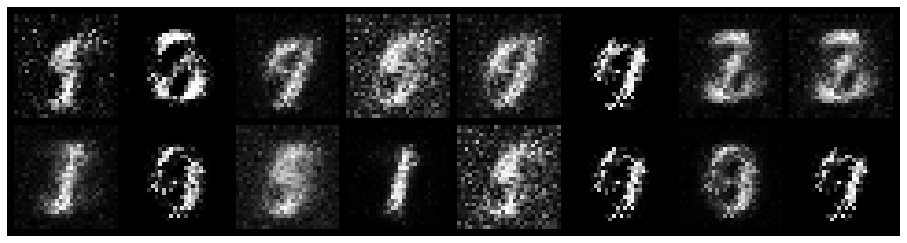

Epoch: [7/200], Batch Num: [100/600]
Discriminator Loss: 0.5055, Generator Loss: 3.4197
D(x): 0.8490, D(G(z)): 0.1118


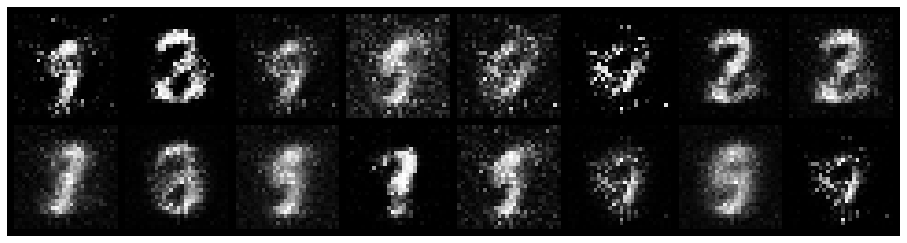

Epoch: [7/200], Batch Num: [200/600]
Discriminator Loss: 0.1600, Generator Loss: 5.1655
D(x): 0.9448, D(G(z)): 0.0589


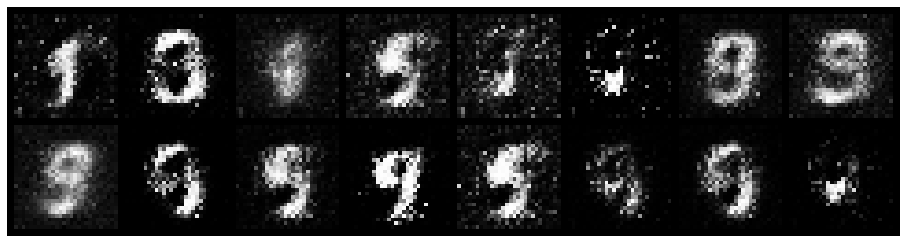

Epoch: [7/200], Batch Num: [300/600]
Discriminator Loss: 0.3696, Generator Loss: 2.8480
D(x): 0.8919, D(G(z)): 0.1512


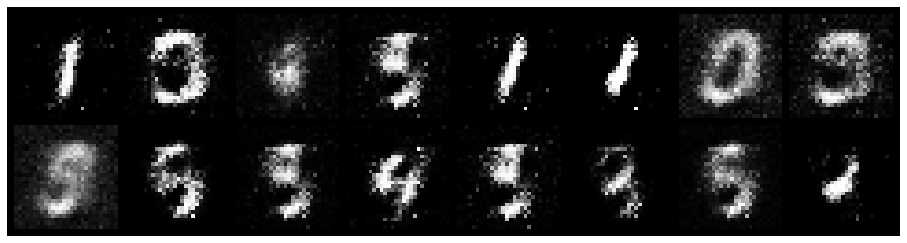

Epoch: [7/200], Batch Num: [400/600]
Discriminator Loss: 0.3476, Generator Loss: 3.0897
D(x): 0.8945, D(G(z)): 0.1136


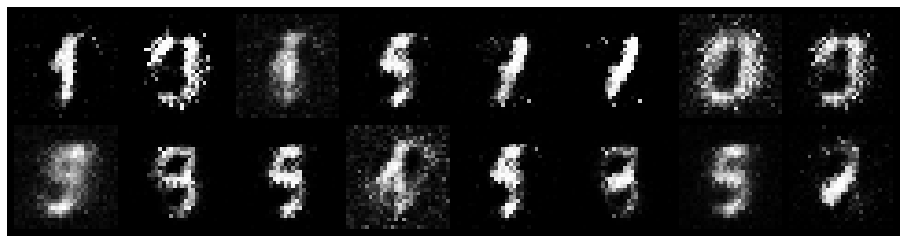

Epoch: [7/200], Batch Num: [500/600]
Discriminator Loss: 0.3930, Generator Loss: 4.2653
D(x): 0.8569, D(G(z)): 0.0612


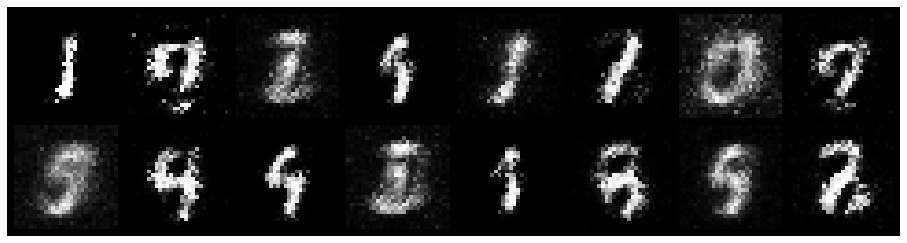

Epoch: [8/200], Batch Num: [0/600]
Discriminator Loss: 0.2818, Generator Loss: 3.9077
D(x): 0.9038, D(G(z)): 0.1109


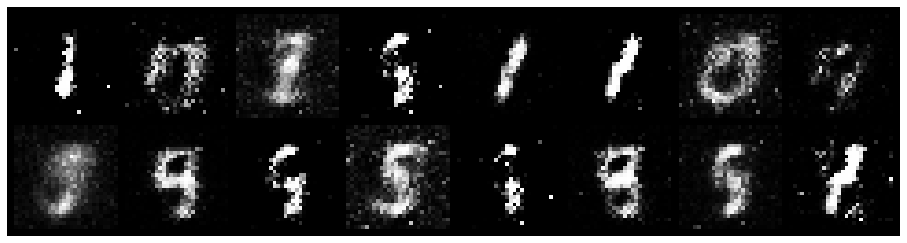

Epoch: [8/200], Batch Num: [100/600]
Discriminator Loss: 0.3790, Generator Loss: 3.1414
D(x): 0.8884, D(G(z)): 0.1326


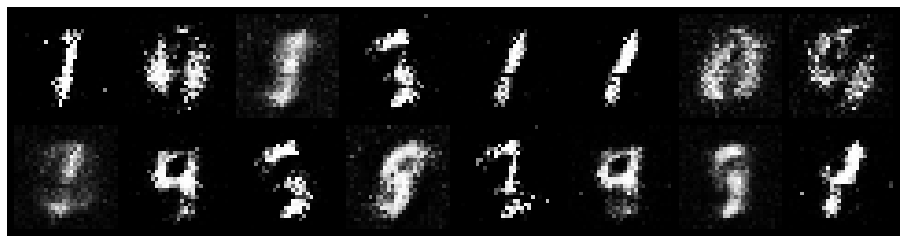

Epoch: [8/200], Batch Num: [200/600]
Discriminator Loss: 0.5260, Generator Loss: 2.8829
D(x): 0.7946, D(G(z)): 0.0990


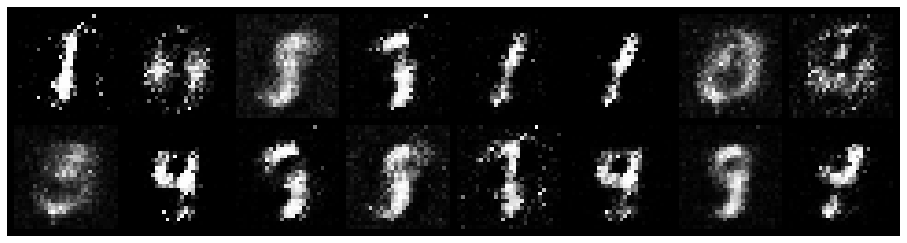

Epoch: [8/200], Batch Num: [300/600]
Discriminator Loss: 0.2547, Generator Loss: 4.4049
D(x): 0.9341, D(G(z)): 0.1028


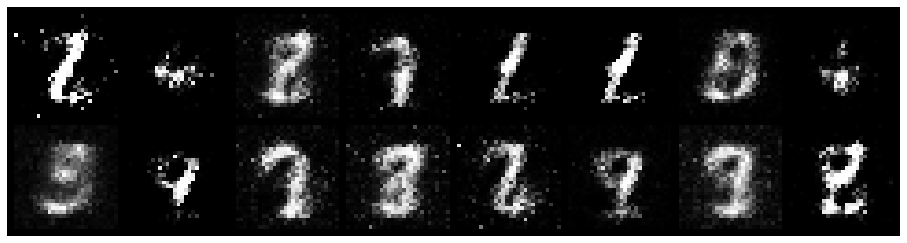

Epoch: [8/200], Batch Num: [400/600]
Discriminator Loss: 0.4888, Generator Loss: 3.2250
D(x): 0.9450, D(G(z)): 0.2260


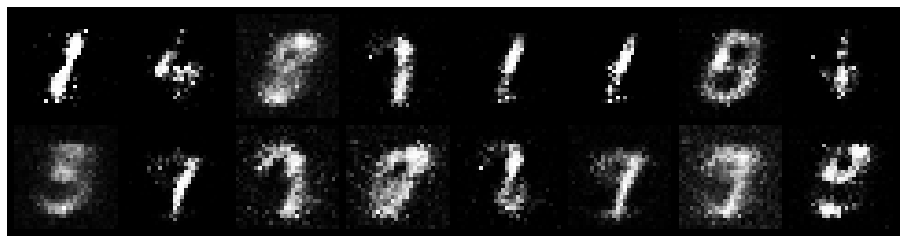

Epoch: [8/200], Batch Num: [500/600]
Discriminator Loss: 0.4816, Generator Loss: 2.9136
D(x): 0.8189, D(G(z)): 0.0958


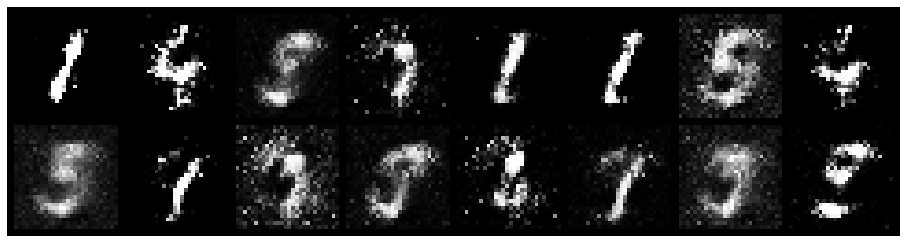

Epoch: [9/200], Batch Num: [0/600]
Discriminator Loss: 0.7245, Generator Loss: 3.5889
D(x): 0.7405, D(G(z)): 0.1207


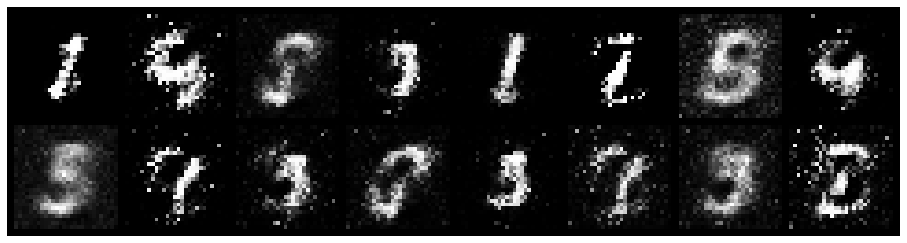

Epoch: [9/200], Batch Num: [100/600]
Discriminator Loss: 0.3339, Generator Loss: 4.0646
D(x): 0.8909, D(G(z)): 0.0852


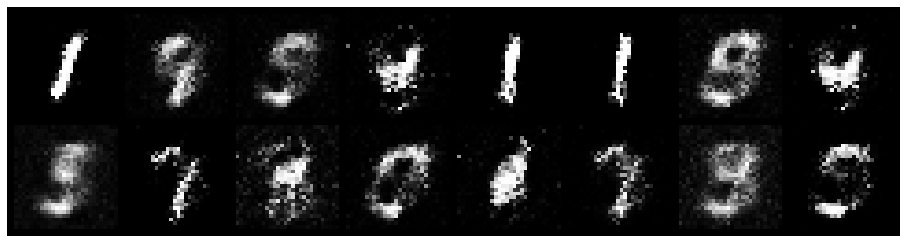

Epoch: [9/200], Batch Num: [200/600]
Discriminator Loss: 0.4079, Generator Loss: 2.7028
D(x): 0.8998, D(G(z)): 0.1842


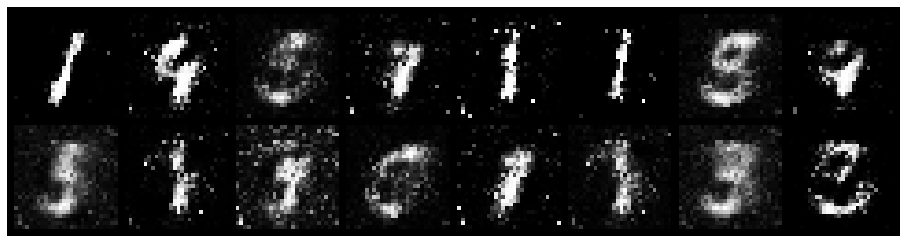

Epoch: [9/200], Batch Num: [300/600]
Discriminator Loss: 0.3211, Generator Loss: 4.0119
D(x): 0.8935, D(G(z)): 0.1146


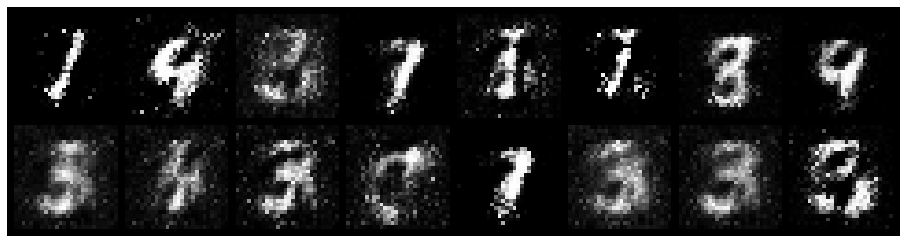

Epoch: [9/200], Batch Num: [400/600]
Discriminator Loss: 0.4958, Generator Loss: 3.2322
D(x): 0.8321, D(G(z)): 0.1439


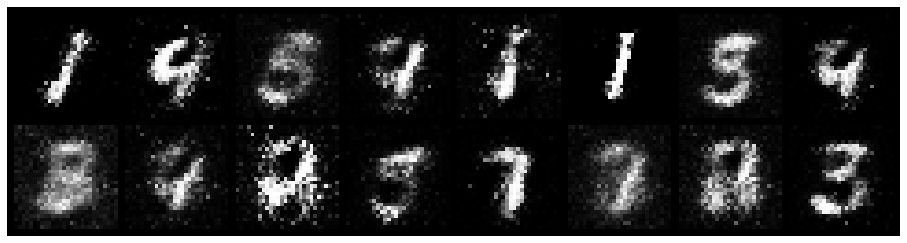

Epoch: [9/200], Batch Num: [500/600]
Discriminator Loss: 0.6502, Generator Loss: 2.3234
D(x): 0.8075, D(G(z)): 0.2117


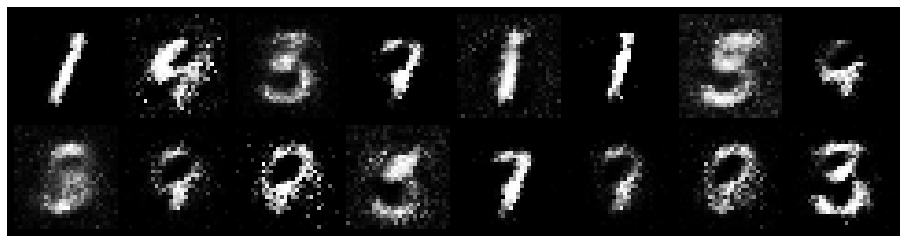

Epoch: [10/200], Batch Num: [0/600]
Discriminator Loss: 0.8302, Generator Loss: 2.3181
D(x): 0.7309, D(G(z)): 0.2125


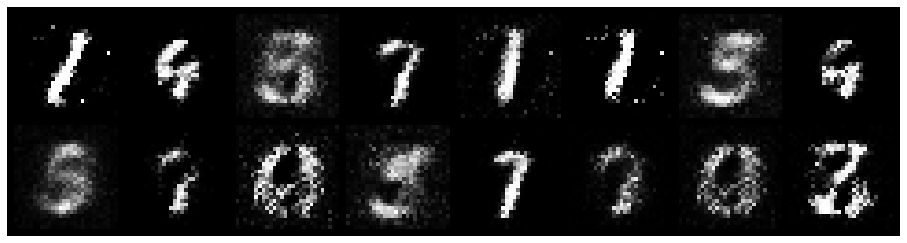

Epoch: [10/200], Batch Num: [100/600]
Discriminator Loss: 0.6118, Generator Loss: 2.7233
D(x): 0.7640, D(G(z)): 0.1470


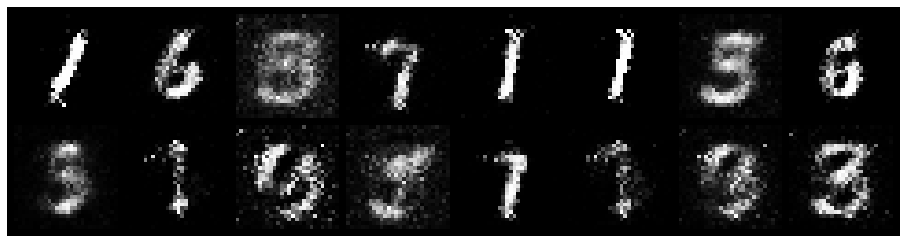

Epoch: [10/200], Batch Num: [200/600]
Discriminator Loss: 0.4954, Generator Loss: 2.3123
D(x): 0.8157, D(G(z)): 0.1443


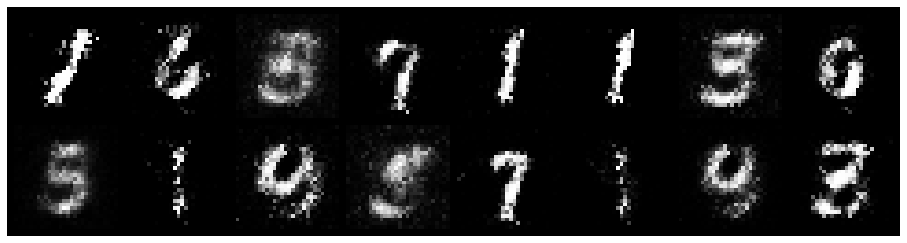

Epoch: [10/200], Batch Num: [300/600]
Discriminator Loss: 0.7716, Generator Loss: 2.0778
D(x): 0.7581, D(G(z)): 0.1873


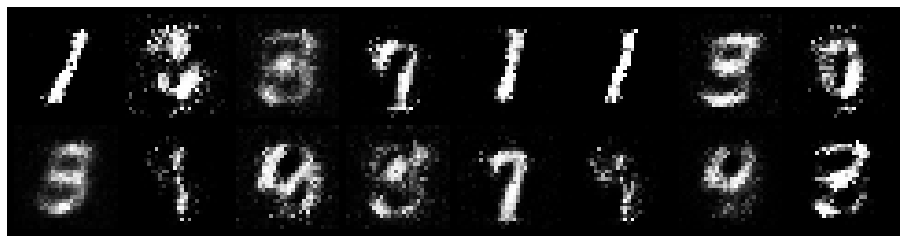

Epoch: [10/200], Batch Num: [400/600]
Discriminator Loss: 0.7452, Generator Loss: 2.6331
D(x): 0.7507, D(G(z)): 0.1600


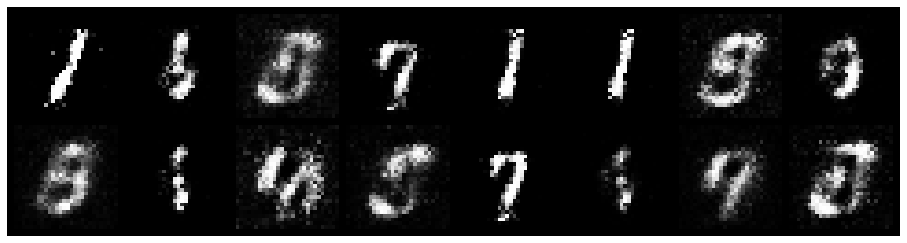

Epoch: [10/200], Batch Num: [500/600]
Discriminator Loss: 0.4264, Generator Loss: 3.6195
D(x): 0.8979, D(G(z)): 0.1553


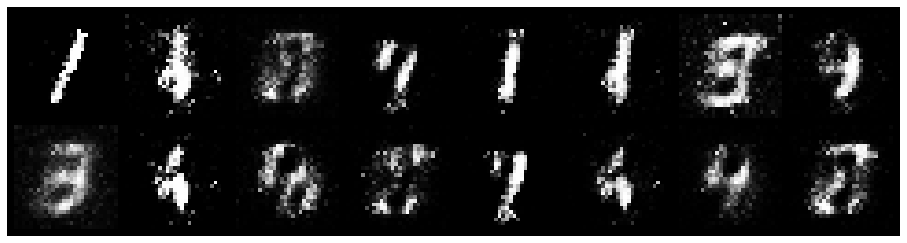

Epoch: [11/200], Batch Num: [0/600]
Discriminator Loss: 0.5415, Generator Loss: 2.4803
D(x): 0.7761, D(G(z)): 0.1262


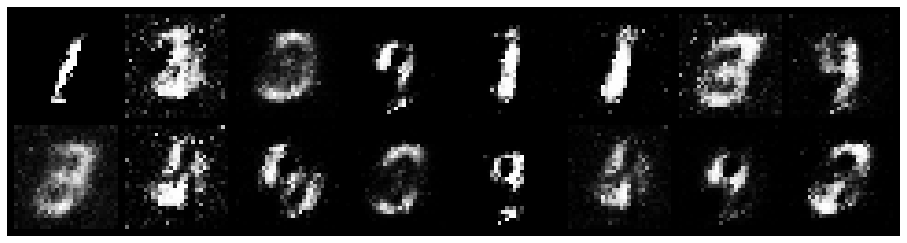

Epoch: [11/200], Batch Num: [100/600]
Discriminator Loss: 0.6338, Generator Loss: 2.3540
D(x): 0.8828, D(G(z)): 0.2720


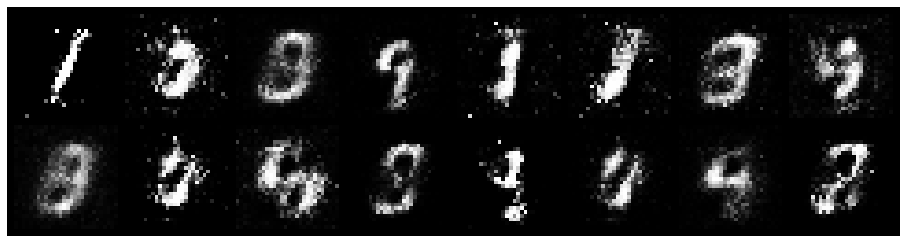

Epoch: [11/200], Batch Num: [200/600]
Discriminator Loss: 0.6088, Generator Loss: 3.2534
D(x): 0.8029, D(G(z)): 0.1343


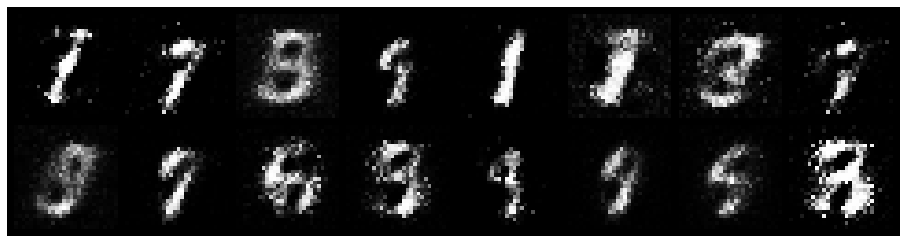

Epoch: [11/200], Batch Num: [300/600]
Discriminator Loss: 0.4496, Generator Loss: 3.0736
D(x): 0.8639, D(G(z)): 0.1468


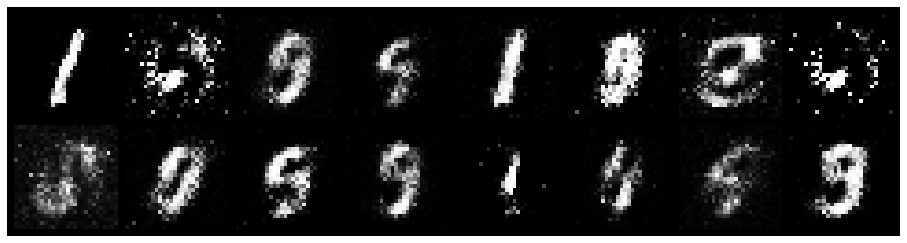

Epoch: [11/200], Batch Num: [400/600]
Discriminator Loss: 0.8253, Generator Loss: 2.8628
D(x): 0.7039, D(G(z)): 0.1963


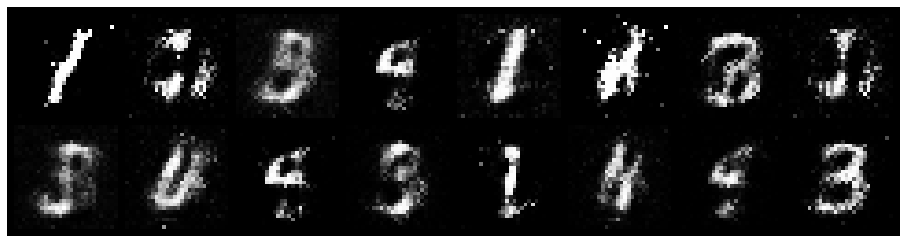

Epoch: [11/200], Batch Num: [500/600]
Discriminator Loss: 0.8267, Generator Loss: 1.8340
D(x): 0.7504, D(G(z)): 0.2406


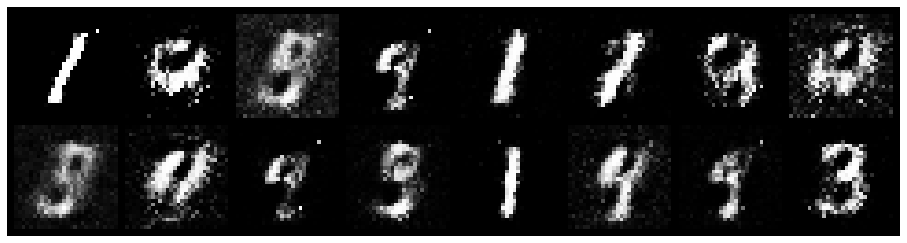

Epoch: [12/200], Batch Num: [0/600]
Discriminator Loss: 0.6625, Generator Loss: 2.0158
D(x): 0.7428, D(G(z)): 0.1779


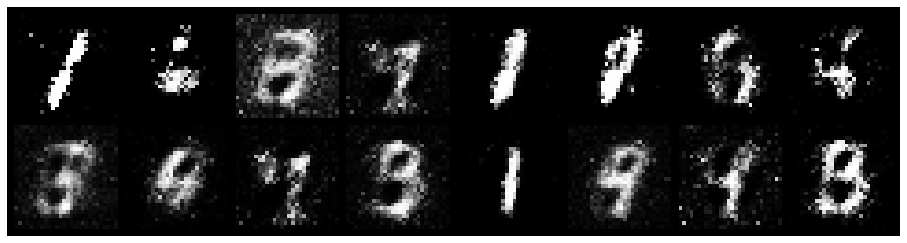

Epoch: [12/200], Batch Num: [100/600]
Discriminator Loss: 0.7557, Generator Loss: 1.7828
D(x): 0.8322, D(G(z)): 0.3097


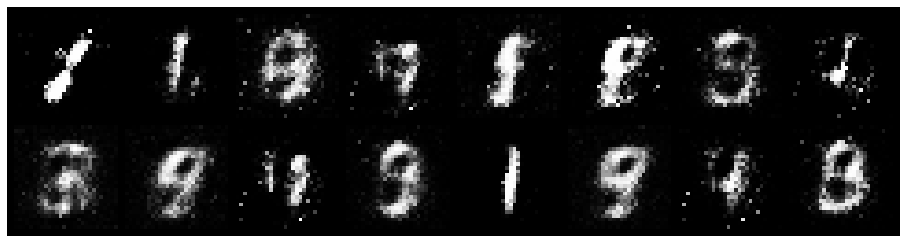

Epoch: [12/200], Batch Num: [200/600]
Discriminator Loss: 0.7262, Generator Loss: 2.1993
D(x): 0.7850, D(G(z)): 0.2699


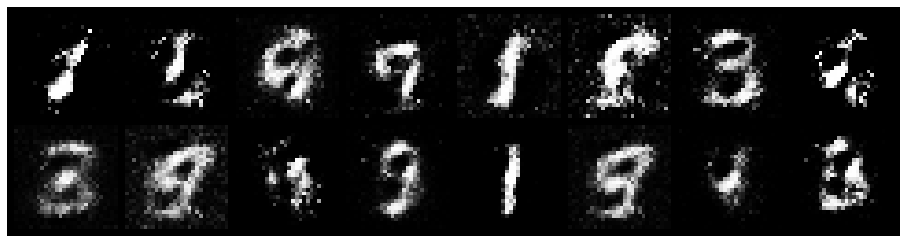

Epoch: [12/200], Batch Num: [300/600]
Discriminator Loss: 0.6826, Generator Loss: 1.6392
D(x): 0.8313, D(G(z)): 0.2662


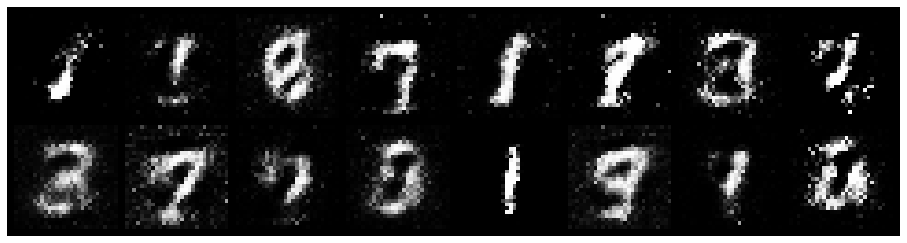

Epoch: [12/200], Batch Num: [400/600]
Discriminator Loss: 0.6384, Generator Loss: 2.5102
D(x): 0.7184, D(G(z)): 0.1218


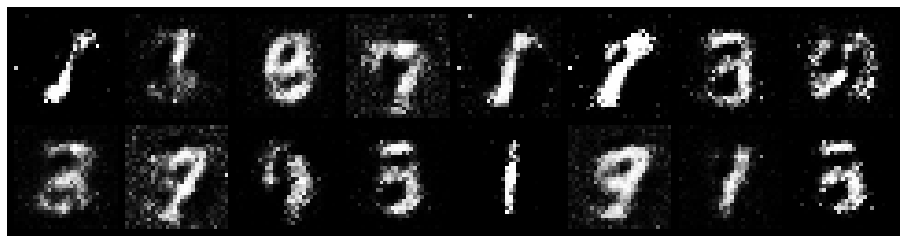

Epoch: [12/200], Batch Num: [500/600]
Discriminator Loss: 0.7061, Generator Loss: 2.3278
D(x): 0.7909, D(G(z)): 0.2086


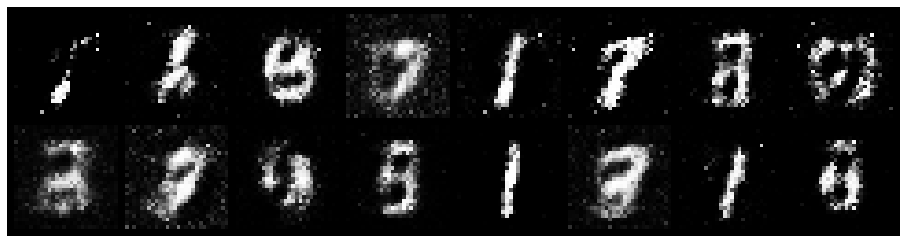

Epoch: [13/200], Batch Num: [0/600]
Discriminator Loss: 0.7618, Generator Loss: 2.1684
D(x): 0.8148, D(G(z)): 0.2763


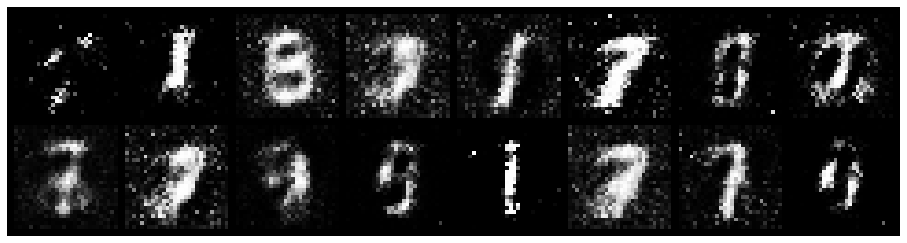

Epoch: [13/200], Batch Num: [100/600]
Discriminator Loss: 0.7079, Generator Loss: 2.1518
D(x): 0.8274, D(G(z)): 0.2830


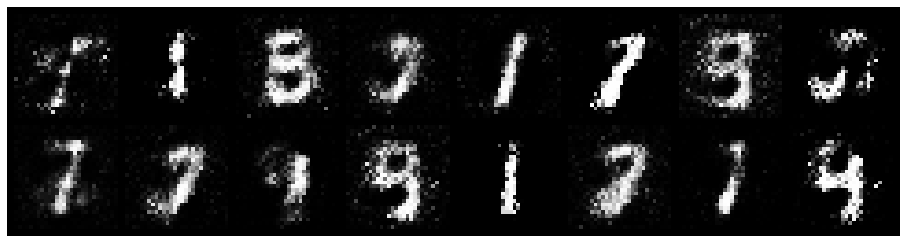

Epoch: [13/200], Batch Num: [200/600]
Discriminator Loss: 0.5254, Generator Loss: 1.8832
D(x): 0.8356, D(G(z)): 0.1995


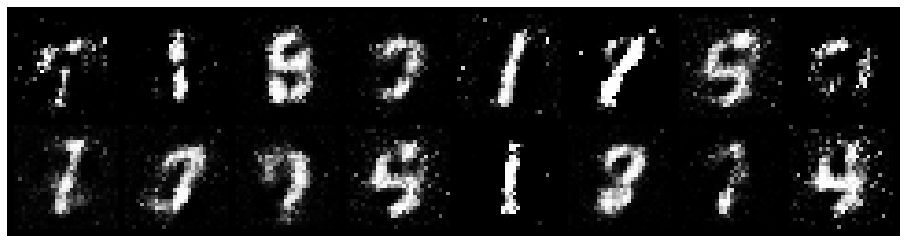

Epoch: [13/200], Batch Num: [300/600]
Discriminator Loss: 0.6309, Generator Loss: 2.1554
D(x): 0.7951, D(G(z)): 0.1754


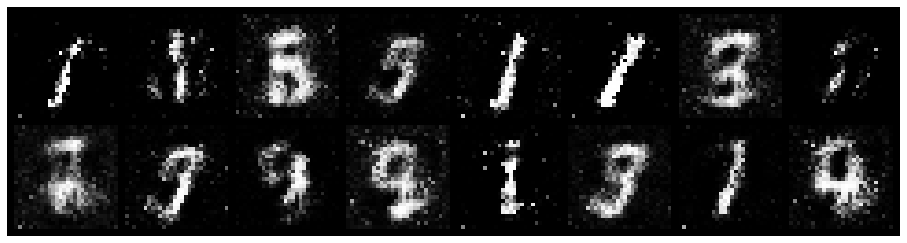

Epoch: [13/200], Batch Num: [400/600]
Discriminator Loss: 0.6647, Generator Loss: 2.5717
D(x): 0.8096, D(G(z)): 0.1975


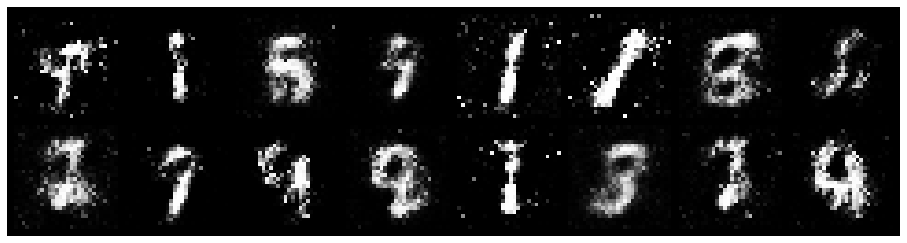

Epoch: [13/200], Batch Num: [500/600]
Discriminator Loss: 0.7558, Generator Loss: 2.1697
D(x): 0.6973, D(G(z)): 0.1999


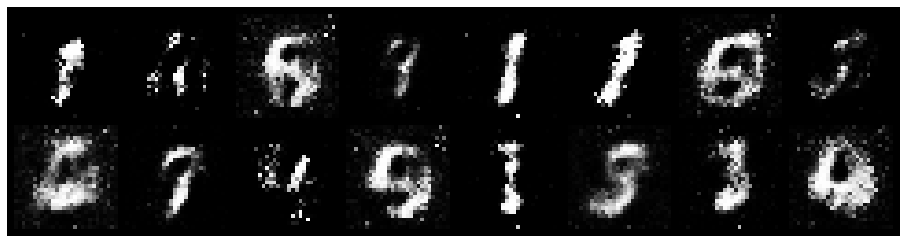

Epoch: [14/200], Batch Num: [0/600]
Discriminator Loss: 0.9170, Generator Loss: 1.5968
D(x): 0.7898, D(G(z)): 0.3570


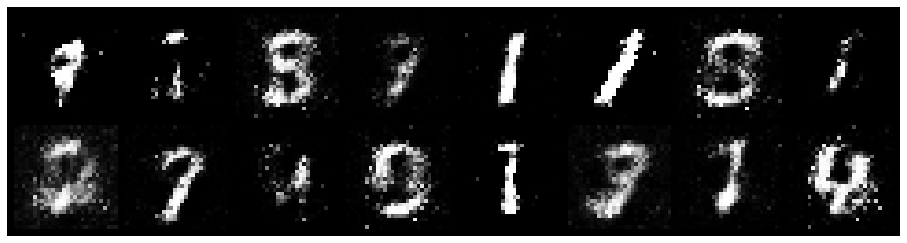

Epoch: [14/200], Batch Num: [100/600]
Discriminator Loss: 0.4469, Generator Loss: 2.5876
D(x): 0.8643, D(G(z)): 0.1799


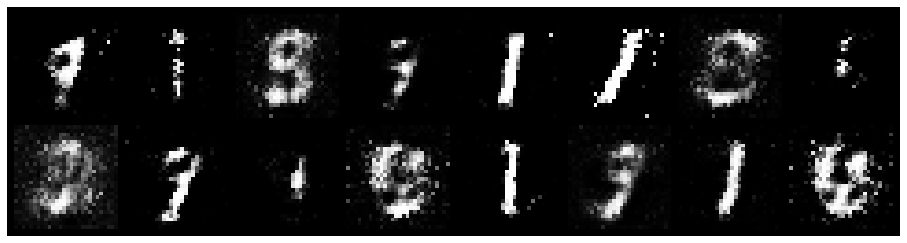

Epoch: [14/200], Batch Num: [200/600]
Discriminator Loss: 0.6969, Generator Loss: 2.6243
D(x): 0.7241, D(G(z)): 0.1420


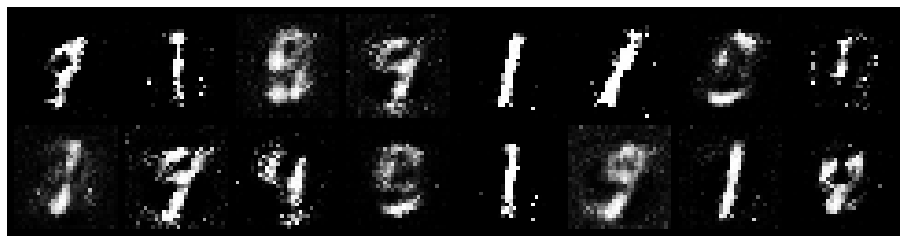

Epoch: [14/200], Batch Num: [300/600]
Discriminator Loss: 0.7018, Generator Loss: 2.2434
D(x): 0.7791, D(G(z)): 0.2236


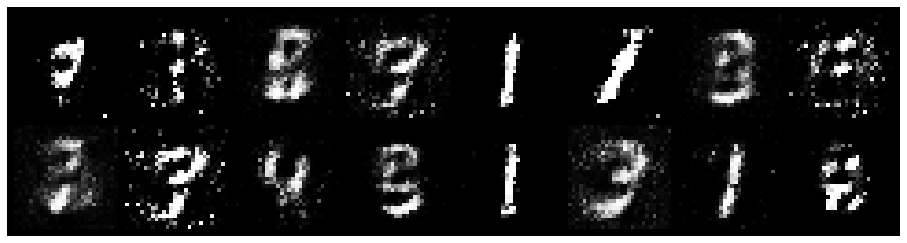

Epoch: [14/200], Batch Num: [400/600]
Discriminator Loss: 0.9173, Generator Loss: 1.9603
D(x): 0.6729, D(G(z)): 0.2235


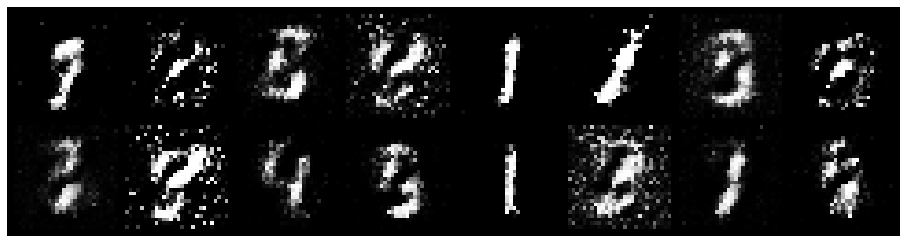

Epoch: [14/200], Batch Num: [500/600]
Discriminator Loss: 0.7602, Generator Loss: 2.0586
D(x): 0.6991, D(G(z)): 0.1574


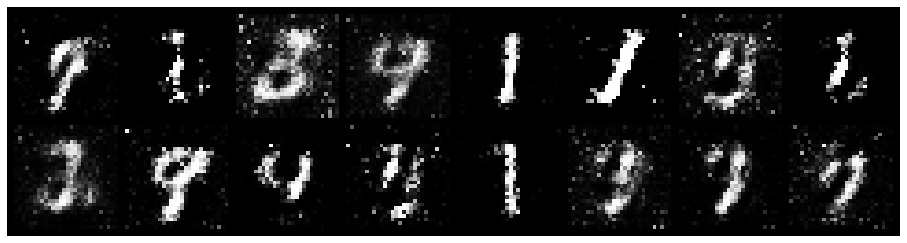

Epoch: [15/200], Batch Num: [0/600]
Discriminator Loss: 0.5768, Generator Loss: 3.0229
D(x): 0.7887, D(G(z)): 0.1655


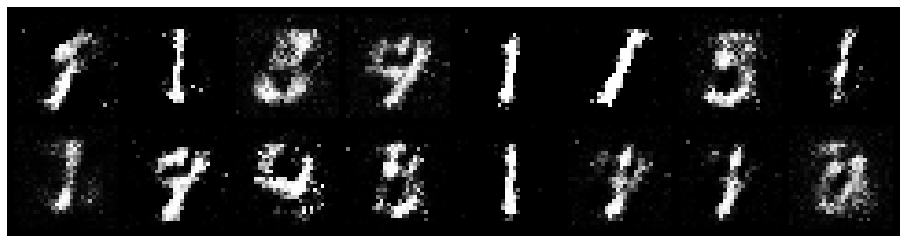

Epoch: [15/200], Batch Num: [100/600]
Discriminator Loss: 0.5903, Generator Loss: 2.4780
D(x): 0.7892, D(G(z)): 0.2060


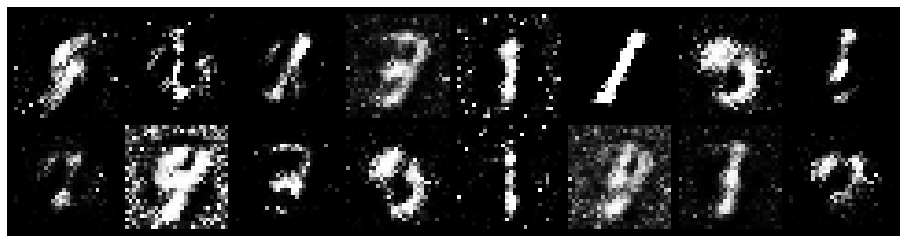

Epoch: [15/200], Batch Num: [200/600]
Discriminator Loss: 0.7559, Generator Loss: 2.0863
D(x): 0.7193, D(G(z)): 0.2081


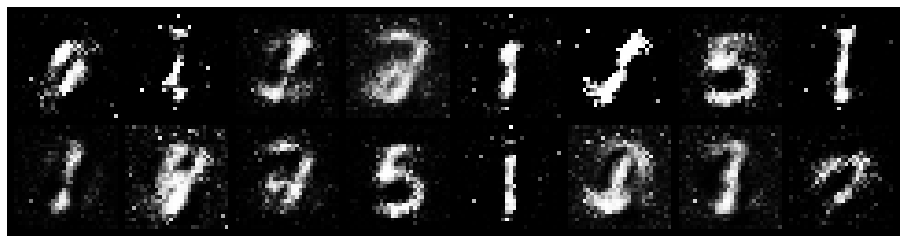

Epoch: [15/200], Batch Num: [300/600]
Discriminator Loss: 0.6160, Generator Loss: 2.4635
D(x): 0.7724, D(G(z)): 0.1870


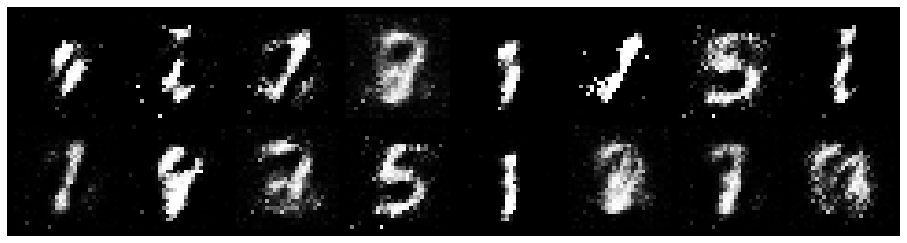

Epoch: [15/200], Batch Num: [400/600]
Discriminator Loss: 0.6629, Generator Loss: 1.9166
D(x): 0.7978, D(G(z)): 0.2746


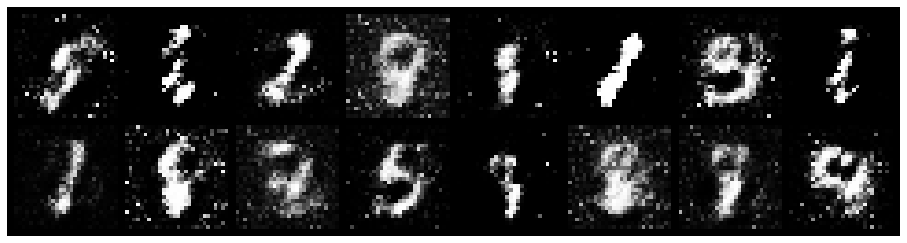

Epoch: [15/200], Batch Num: [500/600]
Discriminator Loss: 0.6097, Generator Loss: 3.2619
D(x): 0.7630, D(G(z)): 0.1295


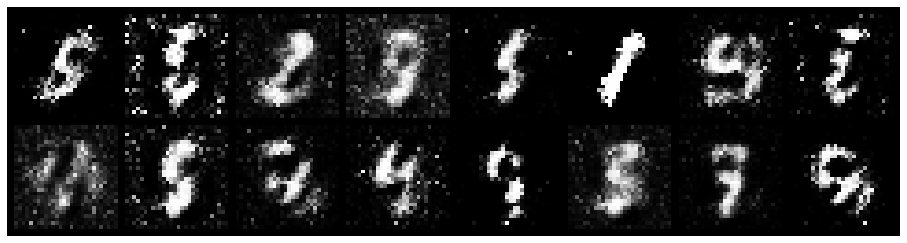

Epoch: [16/200], Batch Num: [0/600]
Discriminator Loss: 0.7143, Generator Loss: 2.4302
D(x): 0.8022, D(G(z)): 0.2346


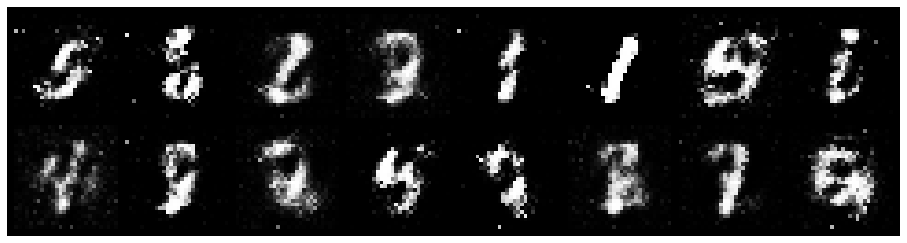

Epoch: [16/200], Batch Num: [100/600]
Discriminator Loss: 0.9436, Generator Loss: 2.1634
D(x): 0.6639, D(G(z)): 0.2337


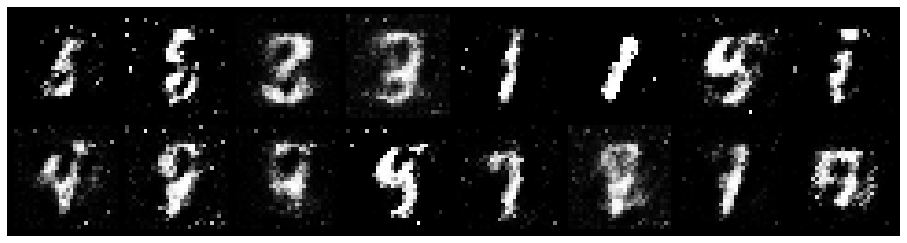

Epoch: [16/200], Batch Num: [200/600]
Discriminator Loss: 0.8537, Generator Loss: 2.0908
D(x): 0.6964, D(G(z)): 0.2047


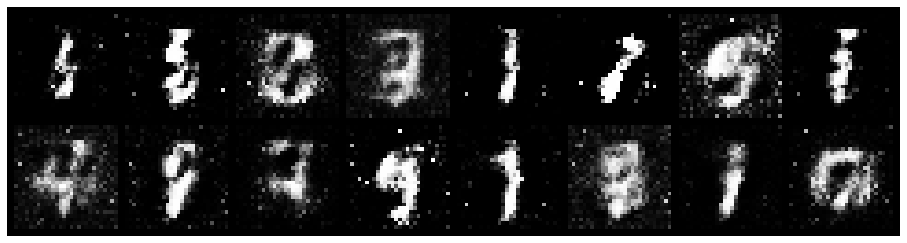

Epoch: [16/200], Batch Num: [300/600]
Discriminator Loss: 0.7358, Generator Loss: 2.1018
D(x): 0.8083, D(G(z)): 0.2682


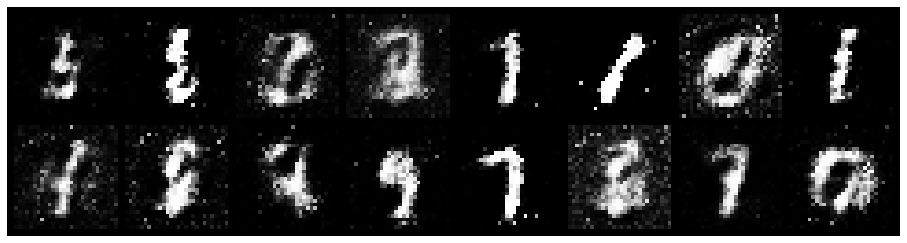

Epoch: [16/200], Batch Num: [400/600]
Discriminator Loss: 0.6927, Generator Loss: 2.4707
D(x): 0.8617, D(G(z)): 0.2909


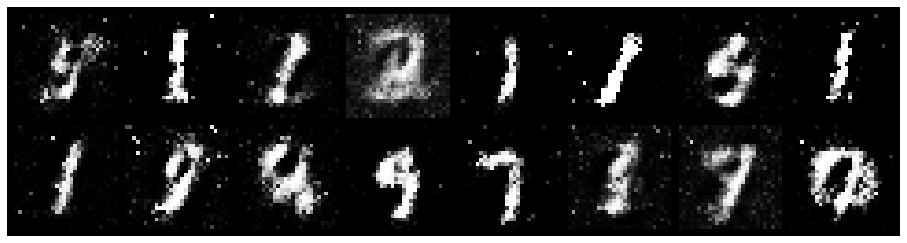

Epoch: [16/200], Batch Num: [500/600]
Discriminator Loss: 0.9088, Generator Loss: 2.0270
D(x): 0.7176, D(G(z)): 0.2620


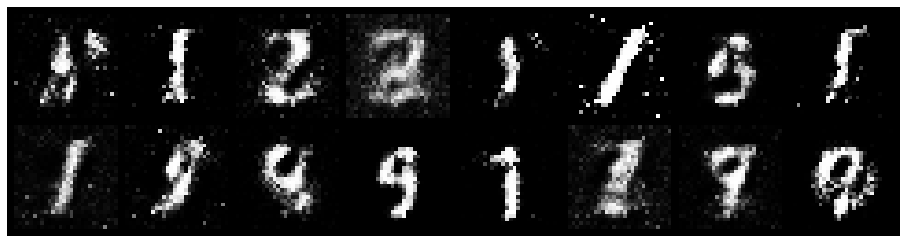

Epoch: [17/200], Batch Num: [0/600]
Discriminator Loss: 0.7735, Generator Loss: 1.4501
D(x): 0.8472, D(G(z)): 0.3145


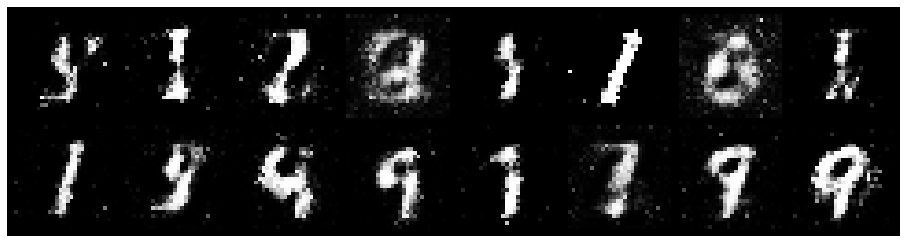

Epoch: [17/200], Batch Num: [100/600]
Discriminator Loss: 0.8831, Generator Loss: 1.7847
D(x): 0.8053, D(G(z)): 0.3224


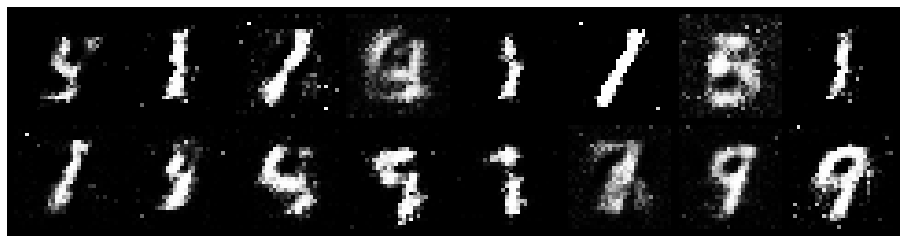

Epoch: [17/200], Batch Num: [200/600]
Discriminator Loss: 0.8818, Generator Loss: 1.8176
D(x): 0.7662, D(G(z)): 0.3266


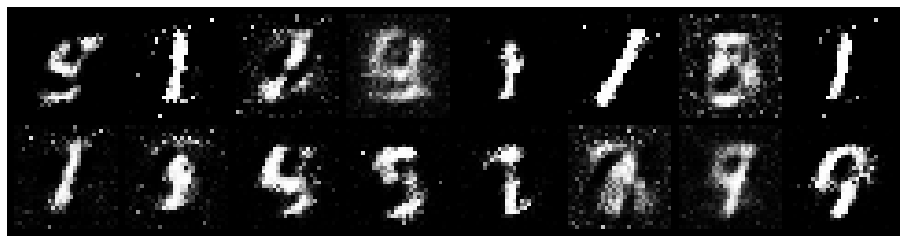

Epoch: [17/200], Batch Num: [300/600]
Discriminator Loss: 0.9270, Generator Loss: 2.1839
D(x): 0.6444, D(G(z)): 0.2202


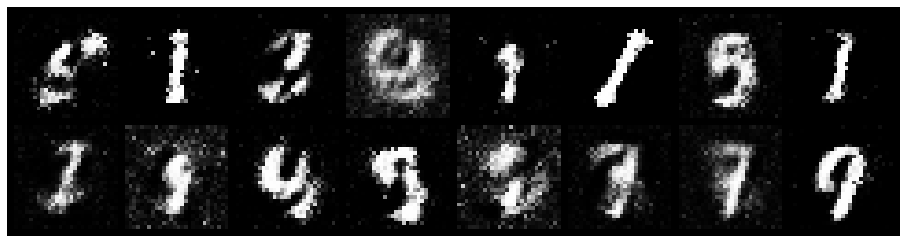

Epoch: [17/200], Batch Num: [400/600]
Discriminator Loss: 0.9048, Generator Loss: 1.8598
D(x): 0.6740, D(G(z)): 0.2334


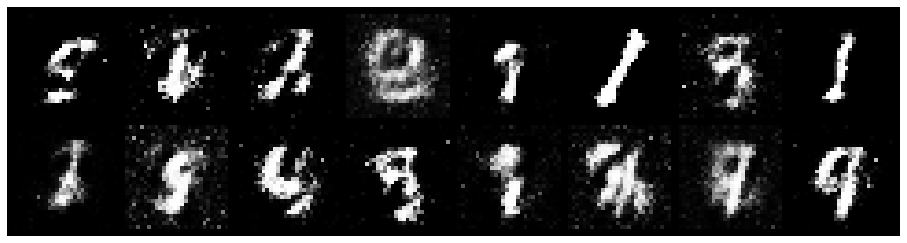

Epoch: [17/200], Batch Num: [500/600]
Discriminator Loss: 0.7047, Generator Loss: 1.5791
D(x): 0.8555, D(G(z)): 0.3207


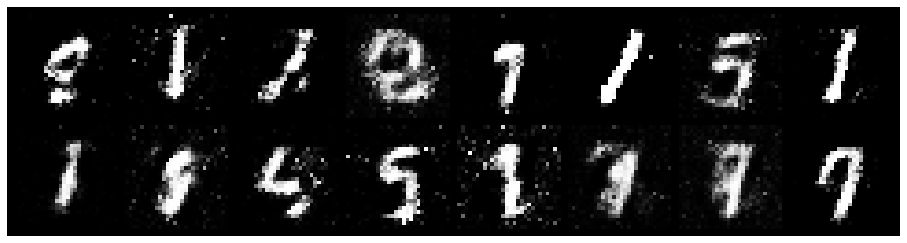

Epoch: [18/200], Batch Num: [0/600]
Discriminator Loss: 0.6839, Generator Loss: 1.7083
D(x): 0.7593, D(G(z)): 0.2231


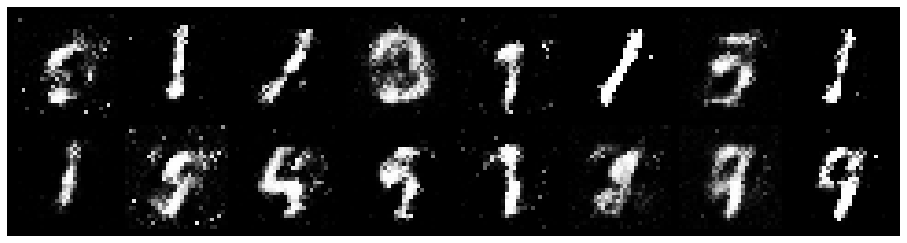

Epoch: [18/200], Batch Num: [100/600]
Discriminator Loss: 0.6247, Generator Loss: 1.9978
D(x): 0.8019, D(G(z)): 0.2363


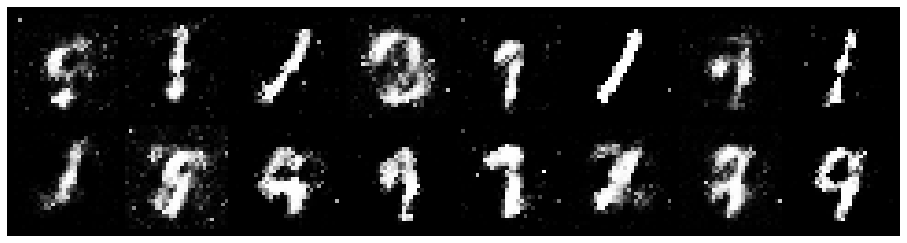

Epoch: [18/200], Batch Num: [200/600]
Discriminator Loss: 0.9063, Generator Loss: 1.2562
D(x): 0.7533, D(G(z)): 0.3509


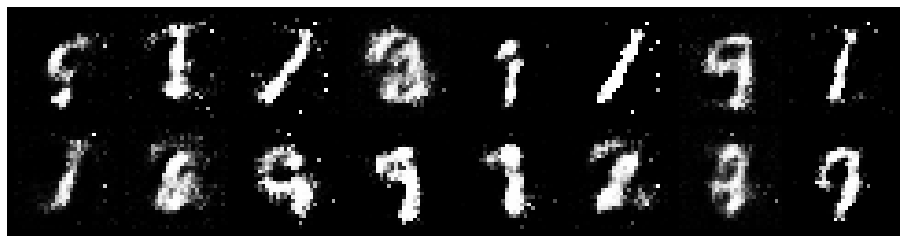

Epoch: [18/200], Batch Num: [300/600]
Discriminator Loss: 0.7677, Generator Loss: 1.8190
D(x): 0.8242, D(G(z)): 0.3323


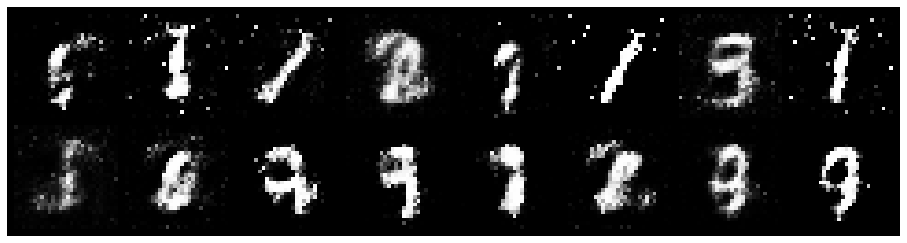

Epoch: [18/200], Batch Num: [400/600]
Discriminator Loss: 0.8404, Generator Loss: 1.9730
D(x): 0.7028, D(G(z)): 0.2297


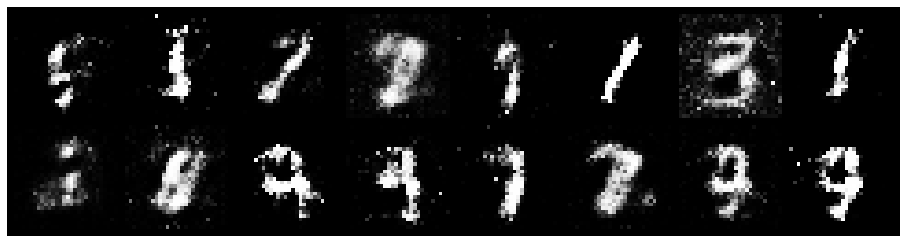

Epoch: [18/200], Batch Num: [500/600]
Discriminator Loss: 0.7192, Generator Loss: 1.7929
D(x): 0.8084, D(G(z)): 0.2655


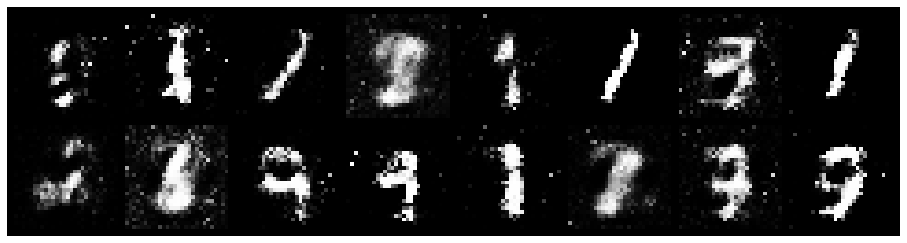

Epoch: [19/200], Batch Num: [0/600]
Discriminator Loss: 0.6881, Generator Loss: 1.4978
D(x): 0.8061, D(G(z)): 0.2754


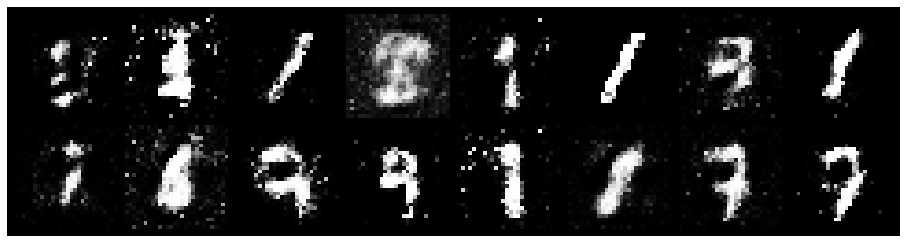

Epoch: [19/200], Batch Num: [100/600]
Discriminator Loss: 0.8179, Generator Loss: 1.5135
D(x): 0.7249, D(G(z)): 0.2468


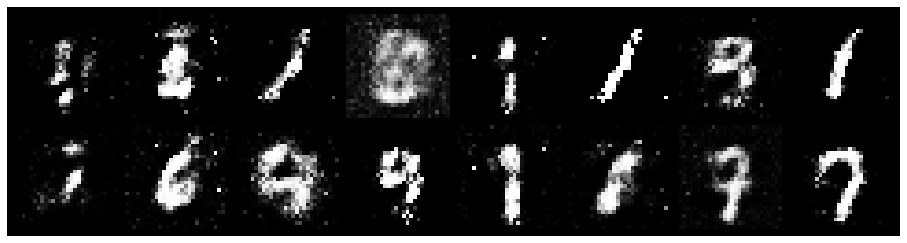

Epoch: [19/200], Batch Num: [200/600]
Discriminator Loss: 0.8034, Generator Loss: 2.0978
D(x): 0.7546, D(G(z)): 0.2641


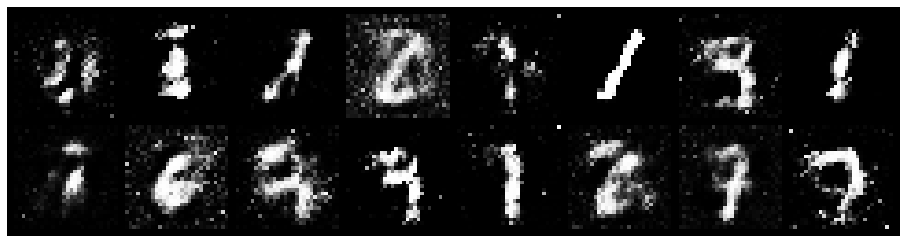

Epoch: [19/200], Batch Num: [300/600]
Discriminator Loss: 0.9235, Generator Loss: 1.4271
D(x): 0.6653, D(G(z)): 0.2577


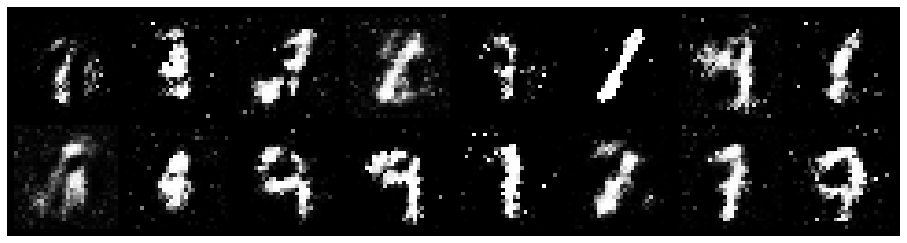

Epoch: [19/200], Batch Num: [400/600]
Discriminator Loss: 0.9138, Generator Loss: 1.8612
D(x): 0.6235, D(G(z)): 0.2311


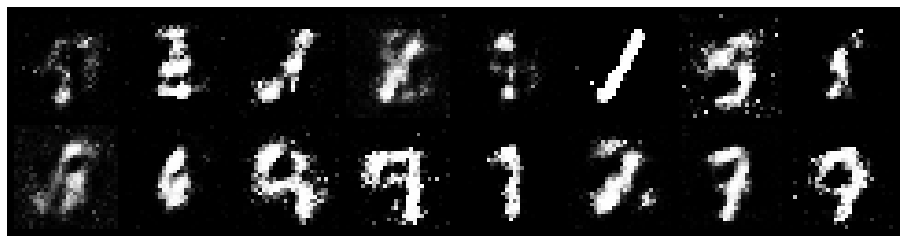

Epoch: [19/200], Batch Num: [500/600]
Discriminator Loss: 0.8690, Generator Loss: 1.8134
D(x): 0.7414, D(G(z)): 0.2882


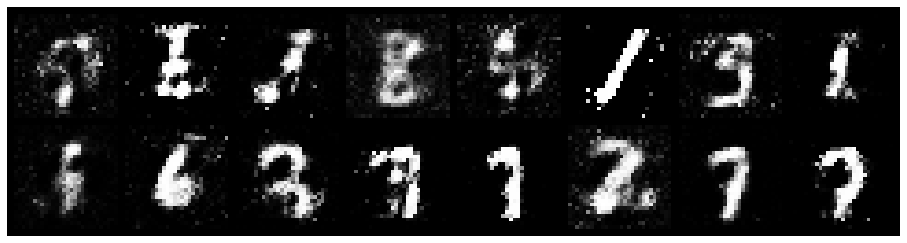

Epoch: [20/200], Batch Num: [0/600]
Discriminator Loss: 0.9794, Generator Loss: 1.2810
D(x): 0.6324, D(G(z)): 0.2673


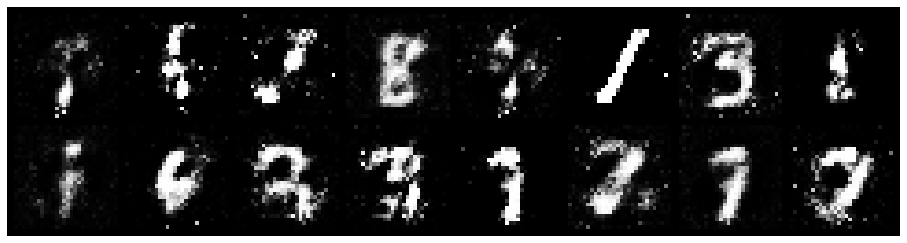

Epoch: [20/200], Batch Num: [100/600]
Discriminator Loss: 0.6585, Generator Loss: 1.7778
D(x): 0.7939, D(G(z)): 0.2704


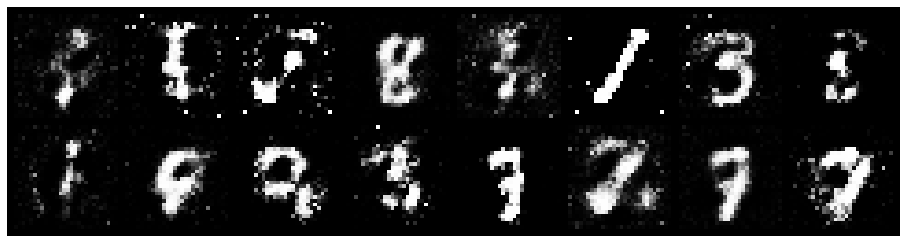

Epoch: [20/200], Batch Num: [200/600]
Discriminator Loss: 0.9394, Generator Loss: 1.6828
D(x): 0.7034, D(G(z)): 0.2695


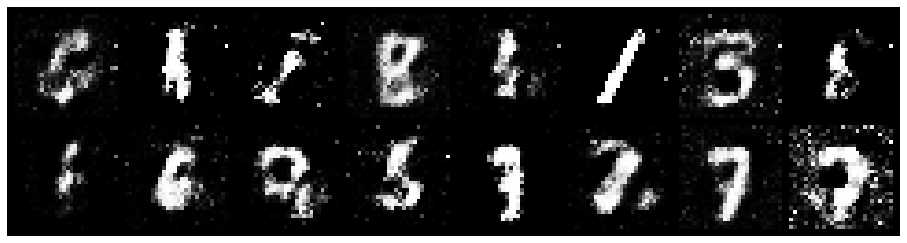

Epoch: [20/200], Batch Num: [300/600]
Discriminator Loss: 0.9843, Generator Loss: 1.5942
D(x): 0.6156, D(G(z)): 0.2339


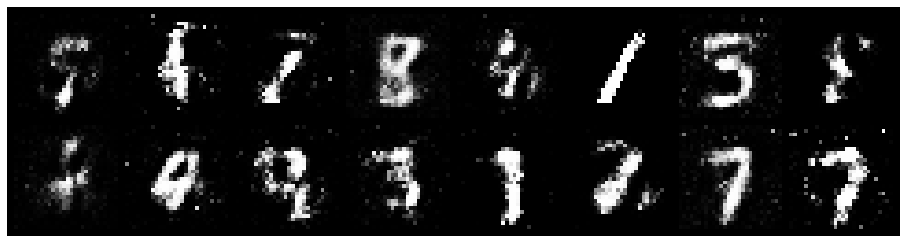

Epoch: [20/200], Batch Num: [400/600]
Discriminator Loss: 0.9266, Generator Loss: 1.5043
D(x): 0.6538, D(G(z)): 0.2866


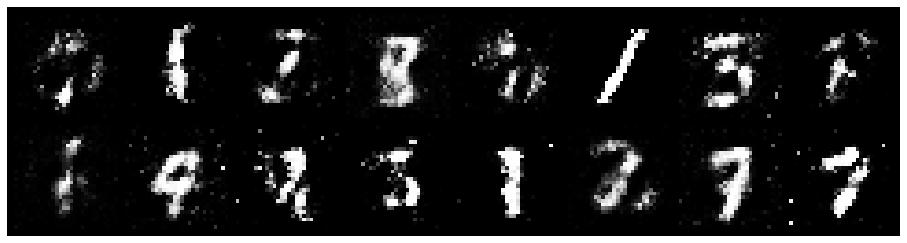

Epoch: [20/200], Batch Num: [500/600]
Discriminator Loss: 0.7338, Generator Loss: 1.6333
D(x): 0.7367, D(G(z)): 0.2401


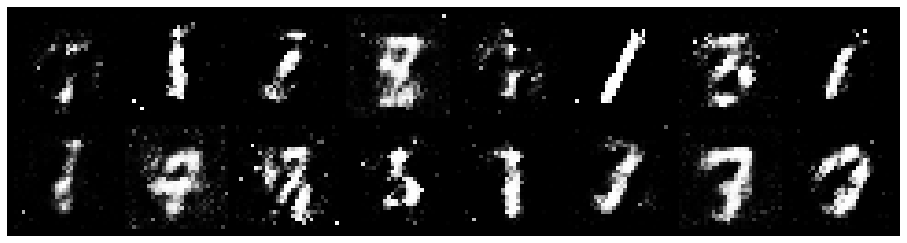

Epoch: [21/200], Batch Num: [0/600]
Discriminator Loss: 0.8368, Generator Loss: 1.2840
D(x): 0.7276, D(G(z)): 0.2780


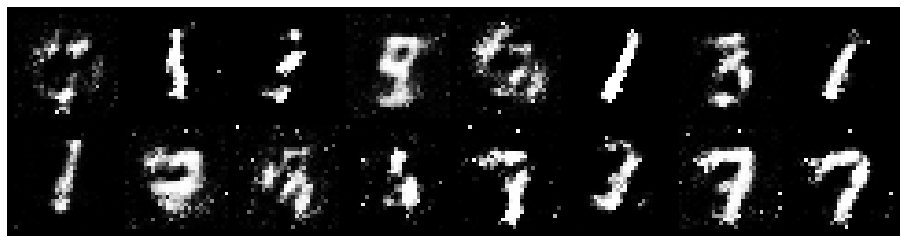

Epoch: [21/200], Batch Num: [100/600]
Discriminator Loss: 1.1951, Generator Loss: 1.0541
D(x): 0.6502, D(G(z)): 0.3962


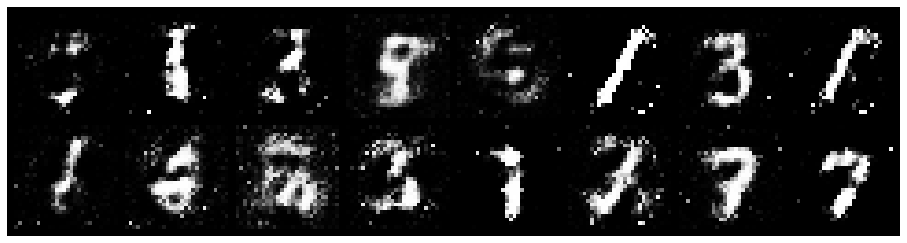

Epoch: [21/200], Batch Num: [200/600]
Discriminator Loss: 0.9807, Generator Loss: 1.7191
D(x): 0.6870, D(G(z)): 0.2561


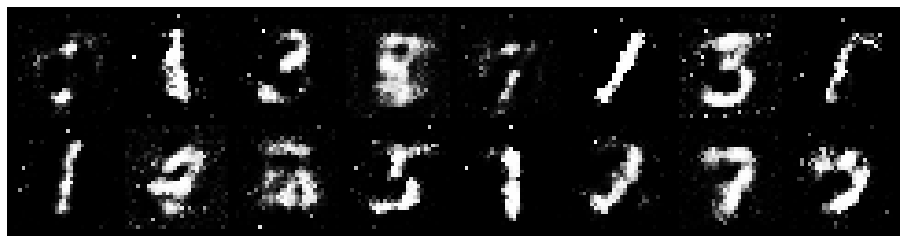

Epoch: [21/200], Batch Num: [300/600]
Discriminator Loss: 1.1116, Generator Loss: 1.3682
D(x): 0.6124, D(G(z)): 0.2760


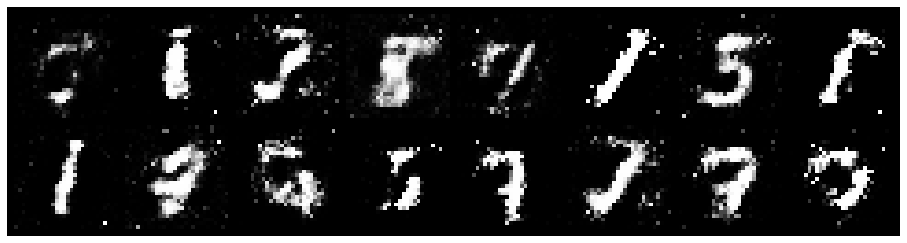

Epoch: [21/200], Batch Num: [400/600]
Discriminator Loss: 1.0610, Generator Loss: 1.4544
D(x): 0.6736, D(G(z)): 0.3142


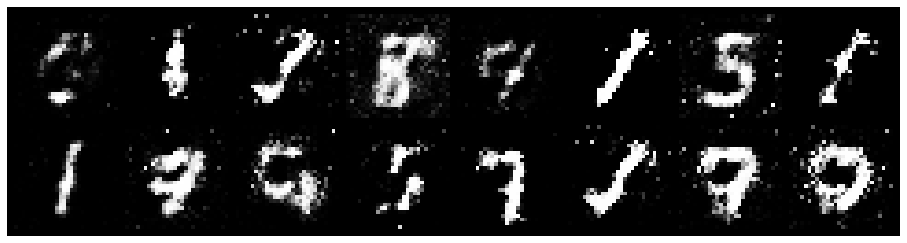

Epoch: [21/200], Batch Num: [500/600]
Discriminator Loss: 0.8910, Generator Loss: 1.7607
D(x): 0.6434, D(G(z)): 0.2265


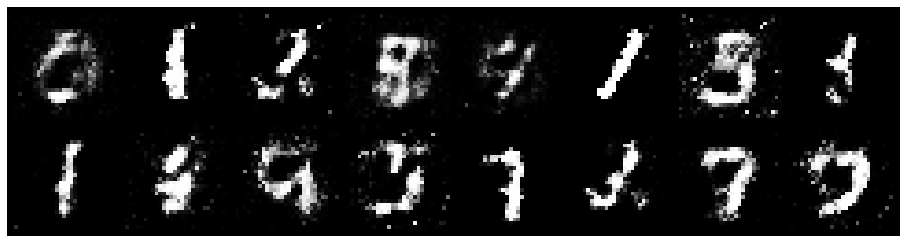

Epoch: [22/200], Batch Num: [0/600]
Discriminator Loss: 0.8386, Generator Loss: 1.8298
D(x): 0.7358, D(G(z)): 0.2983


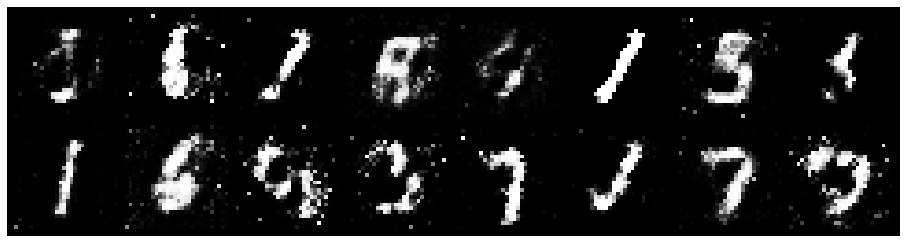

Epoch: [22/200], Batch Num: [100/600]
Discriminator Loss: 0.8985, Generator Loss: 1.2597
D(x): 0.7388, D(G(z)): 0.3386


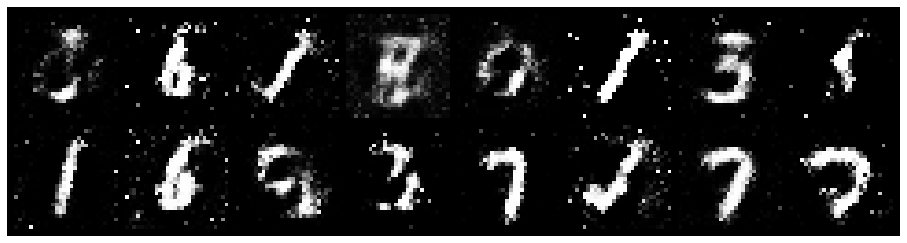

Epoch: [22/200], Batch Num: [200/600]
Discriminator Loss: 1.0308, Generator Loss: 1.9514
D(x): 0.6682, D(G(z)): 0.3106


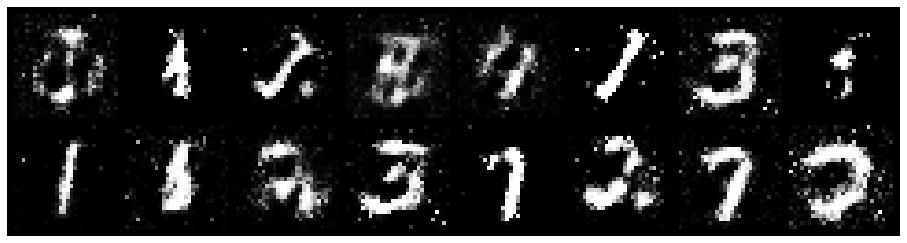

Epoch: [22/200], Batch Num: [300/600]
Discriminator Loss: 0.9949, Generator Loss: 1.5010
D(x): 0.7294, D(G(z)): 0.3822


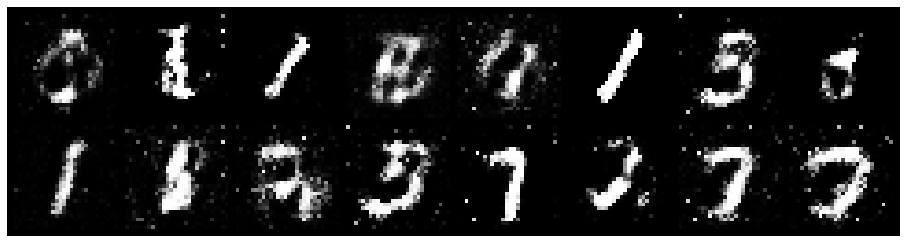

Epoch: [22/200], Batch Num: [400/600]
Discriminator Loss: 0.8962, Generator Loss: 1.9673
D(x): 0.7213, D(G(z)): 0.2496


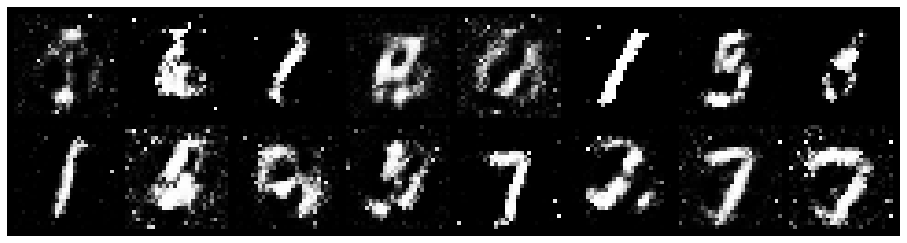

Epoch: [22/200], Batch Num: [500/600]
Discriminator Loss: 0.9115, Generator Loss: 1.6901
D(x): 0.6885, D(G(z)): 0.2660


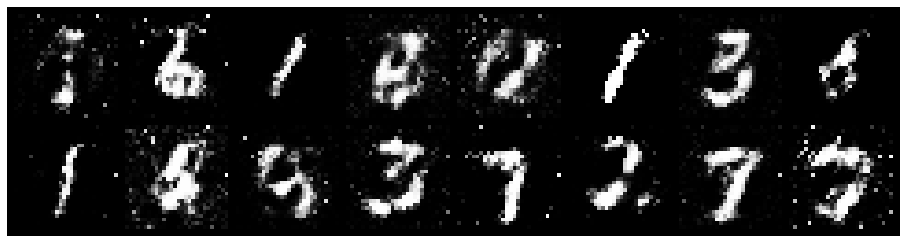

Epoch: [23/200], Batch Num: [0/600]
Discriminator Loss: 0.8815, Generator Loss: 1.6361
D(x): 0.6767, D(G(z)): 0.2582


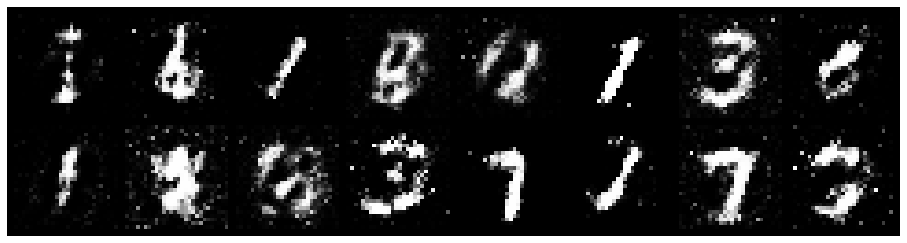

Epoch: [23/200], Batch Num: [100/600]
Discriminator Loss: 1.0008, Generator Loss: 1.8185
D(x): 0.6175, D(G(z)): 0.2109


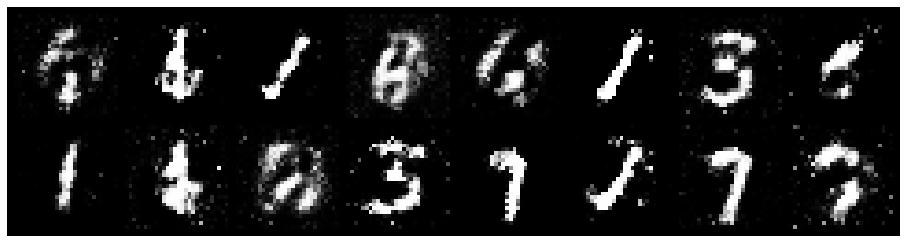

Epoch: [23/200], Batch Num: [200/600]
Discriminator Loss: 1.0518, Generator Loss: 1.2817
D(x): 0.6986, D(G(z)): 0.3736


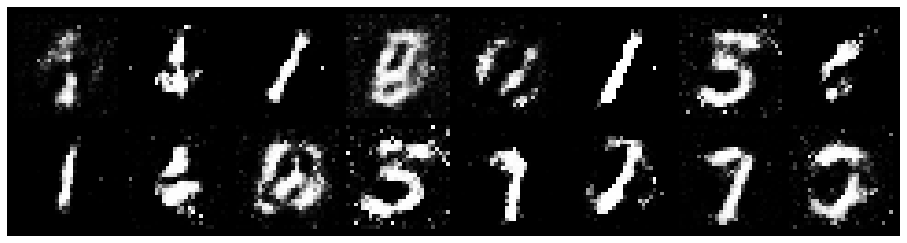

Epoch: [23/200], Batch Num: [300/600]
Discriminator Loss: 1.0745, Generator Loss: 1.6209
D(x): 0.7590, D(G(z)): 0.4030


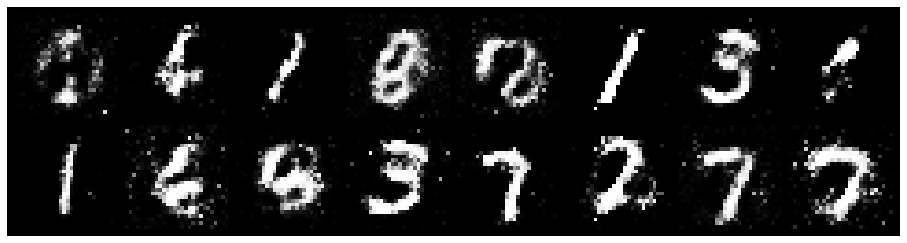

Epoch: [23/200], Batch Num: [400/600]
Discriminator Loss: 0.7726, Generator Loss: 2.1194
D(x): 0.7191, D(G(z)): 0.2302


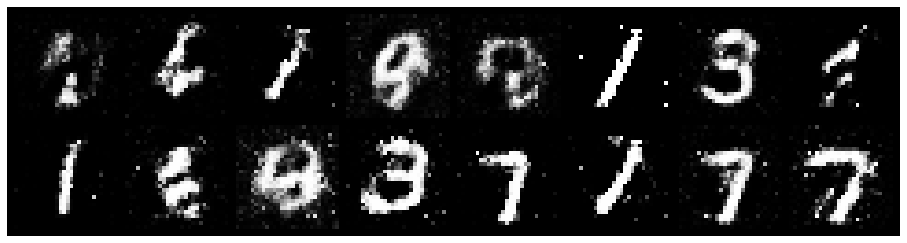

Epoch: [23/200], Batch Num: [500/600]
Discriminator Loss: 0.9718, Generator Loss: 1.6542
D(x): 0.6746, D(G(z)): 0.2987


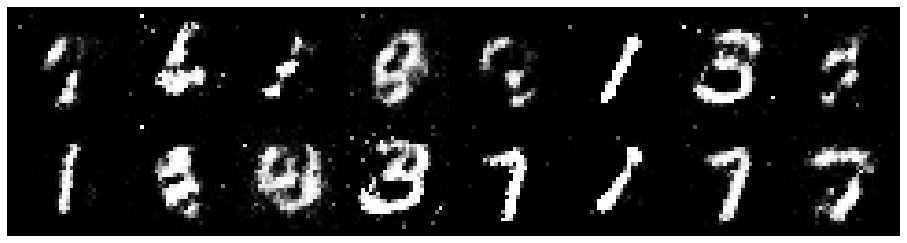

Epoch: [24/200], Batch Num: [0/600]
Discriminator Loss: 0.9221, Generator Loss: 1.3359
D(x): 0.7030, D(G(z)): 0.2899


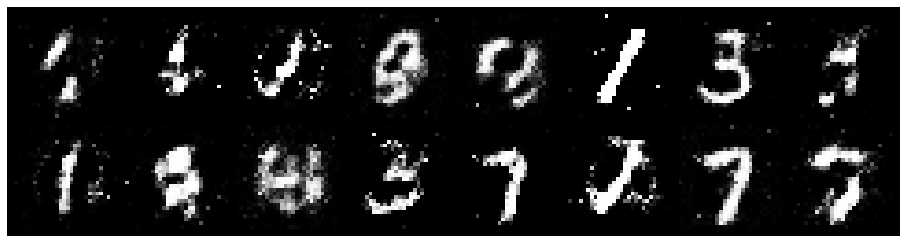

Epoch: [24/200], Batch Num: [100/600]
Discriminator Loss: 0.7741, Generator Loss: 1.7102
D(x): 0.7175, D(G(z)): 0.2499


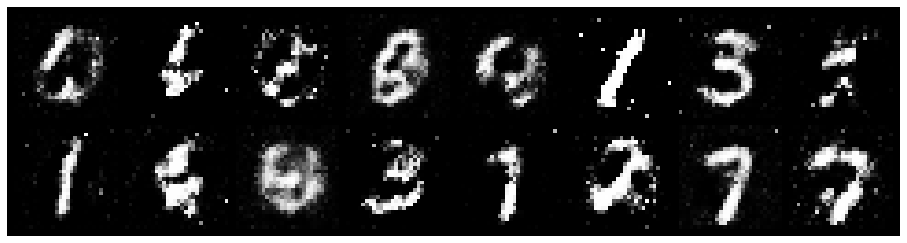

Epoch: [24/200], Batch Num: [200/600]
Discriminator Loss: 0.7175, Generator Loss: 1.5494
D(x): 0.7509, D(G(z)): 0.2641


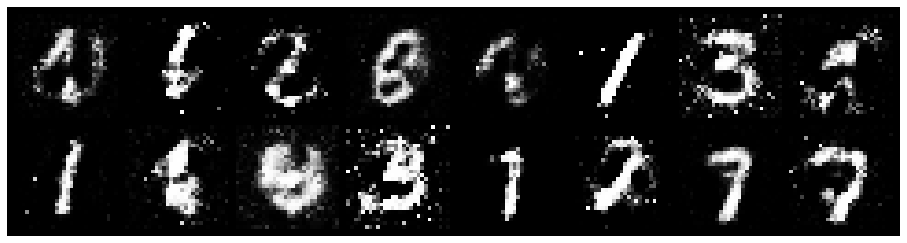

Epoch: [24/200], Batch Num: [300/600]
Discriminator Loss: 0.8472, Generator Loss: 1.2441
D(x): 0.6639, D(G(z)): 0.2654


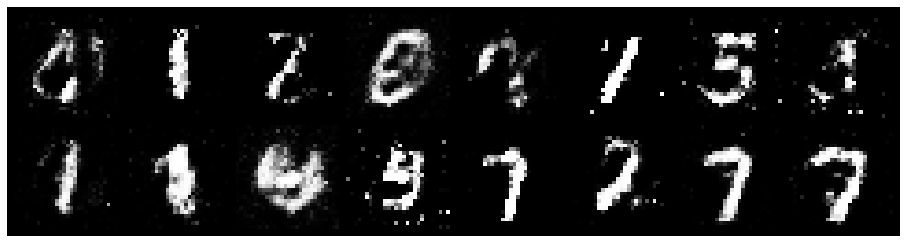

Epoch: [24/200], Batch Num: [400/600]
Discriminator Loss: 0.8460, Generator Loss: 1.8368
D(x): 0.7237, D(G(z)): 0.3155


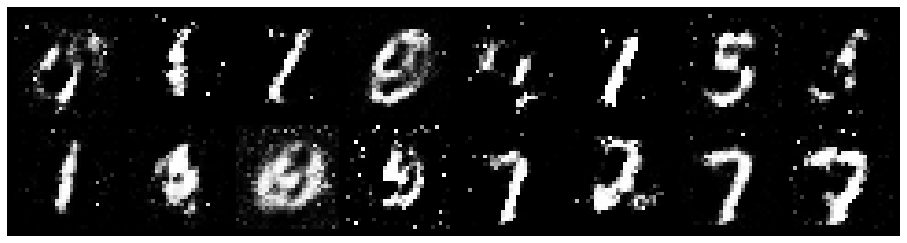

Epoch: [24/200], Batch Num: [500/600]
Discriminator Loss: 0.8196, Generator Loss: 1.5582
D(x): 0.7283, D(G(z)): 0.2927


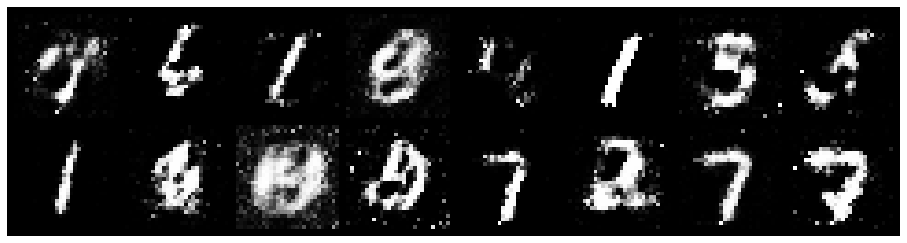

Epoch: [25/200], Batch Num: [0/600]
Discriminator Loss: 1.0453, Generator Loss: 1.5305
D(x): 0.6467, D(G(z)): 0.3112


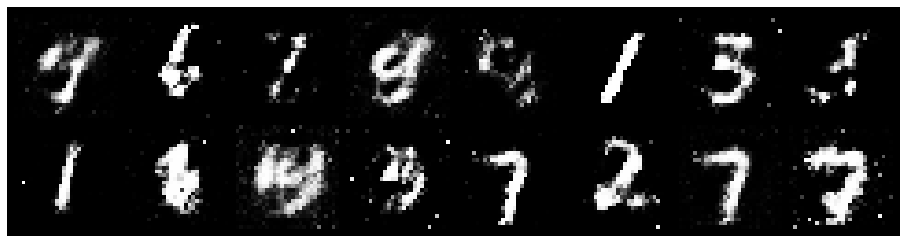

Epoch: [25/200], Batch Num: [100/600]
Discriminator Loss: 0.9027, Generator Loss: 1.4961
D(x): 0.6945, D(G(z)): 0.3041


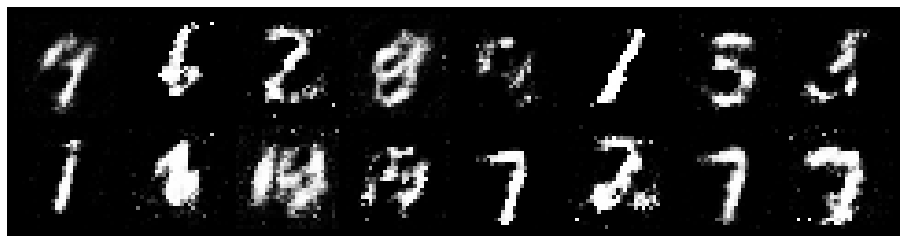

Epoch: [25/200], Batch Num: [200/600]
Discriminator Loss: 0.8568, Generator Loss: 1.7209
D(x): 0.8020, D(G(z)): 0.3790


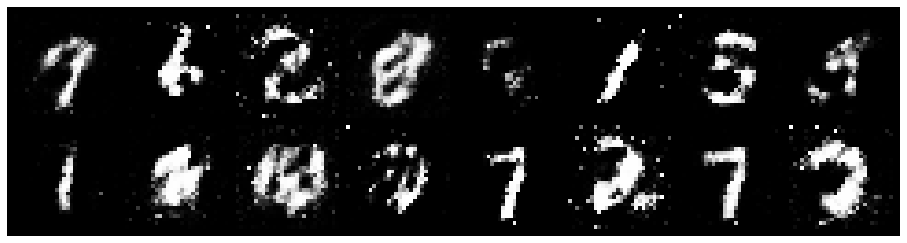

Epoch: [25/200], Batch Num: [300/600]
Discriminator Loss: 0.9710, Generator Loss: 1.6279
D(x): 0.6616, D(G(z)): 0.3038


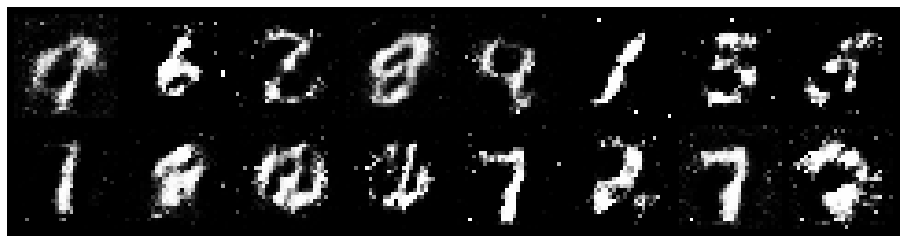

Epoch: [25/200], Batch Num: [400/600]
Discriminator Loss: 0.9879, Generator Loss: 1.1248
D(x): 0.6864, D(G(z)): 0.3717


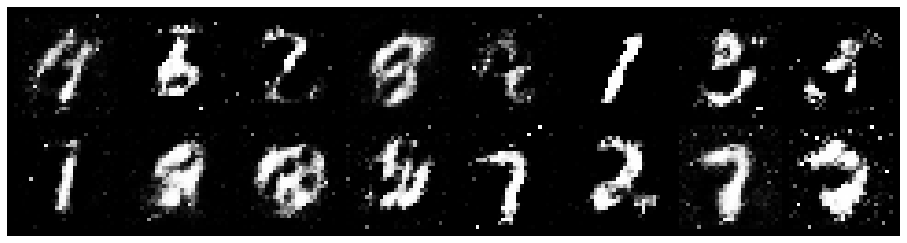

Epoch: [25/200], Batch Num: [500/600]
Discriminator Loss: 0.8978, Generator Loss: 1.4125
D(x): 0.7124, D(G(z)): 0.3548


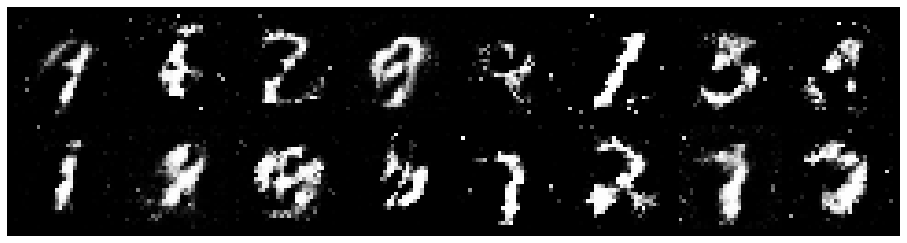

Epoch: [26/200], Batch Num: [0/600]
Discriminator Loss: 0.8543, Generator Loss: 2.0697
D(x): 0.6723, D(G(z)): 0.2543


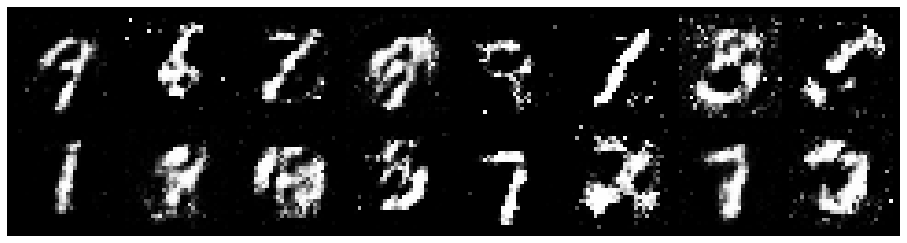

Epoch: [26/200], Batch Num: [100/600]
Discriminator Loss: 0.8034, Generator Loss: 1.5457
D(x): 0.7359, D(G(z)): 0.2759


In [ ]:
# Create logger instance
logger = Logger(model_name = 'VGAN',data_name='MNIST')

# Total number of epoches to train
num_epochs = 200

for epoch in range(num_epochs):
  for n_batch, (real_batch,_) in enumerate(data_loader):
    N = real_batch.size(0)

    # Train discriminater
    real_data = Variable(images_to_vectors(real_batch.to(device)))

    # Generate fake data and detach
    # so gradients are not calculated for generator
    fake_data = generator(noise(N).to(device)).detach()

    # Train descriminator
    d_error,d_pred_real,d_pred_fake=\
    train_discriminator(d_optimizer,real_data,fake_data)

    #train generator
    #Generate fake data
    fake_data = generator(noise(N).to(device))

    g_error = train_generator(g_optimizer,fake_data)

    # log batch error
    logger.log(d_error,g_error,epoch,n_batch,num_batches)

    if (n_batch)%100 == 0:
      test_images = vectors_to_images(generator(test_noise.to(device))).to('cpu')
      test_images = test_images.data

      logger.log_images(
          test_images,num_test_samples,
          epoch,n_batch,num_batches
      );
      # display status Logs
      logger.display_status(
          epoch, num_epochs, n_batch,num_batches,
          d_error,g_error,d_pred_real,d_pred_fake
      )

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# device